# open FIA data points

In [12]:
from glob import glob
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
import folium
from folium.plugins import MarkerCluster
import binascii
import os
import sys
sys.path.append('/content')

%matplotlib inline

# Standard packages
import tempfile
import warnings
import urllib
import shutil
import os

# Workaround for a problem in older rasterio versions
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt" 

# Less standard, but still pip- or conda-installable
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rtree
import shapely
import pickle

# pip install progressbar2, not progressbar
import progressbar

from geopy.geocoders import Nominatim
from rasterio.windows import Window 
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

from src.azuretools import *

latest_wkid = 3857
crs = "EPSG:4326"

# Storage locations are documented at http://aka.ms/ai4edata-naip
blob_root = 'https://naipblobs.blob.core.windows.net/naip'

index_files = ["tile_index.dat", "tile_index.idx", "tiles.p"]
index_blob_root = 'https://naipblobs.blob.core.windows.net/naip-index/rtree/'
temp_dir = os.path.join(tempfile.gettempdir(),'naip')
os.makedirs(temp_dir,exist_ok=True)

# Spatial index that maps lat/lon to NAIP tiles; we'll load this when we first 
# need to access it.
index = None
if index is None:
    index = NAIPTileIndex()
# URL where we've stashed a geojson file with the boundaries of Maryland.  Why do we
# need the boundaries of Maryland?  It's a surprise, you'll have to keep reading to find
# out.
warnings.filterwarnings("ignore")
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
blob = '/home/datablob'
fiafile = f'{blob}/fia_no_pltcn.csv'
plots = gpd.GeoDataFrame(pd.read_csv(fiafile))
plots.Latitude = plots.LAT.astype('float')
plots.Longitude = plots.LON.astype('float')
geometry = [Point(xy) for xy in zip(plots.Longitude, plots.Latitude)]
crs = {'init': 'epsg:4326'} 
geo_df = gpd.GeoDataFrame(plots, crs=crs, geometry=geometry)

#subset by STATECD
statecd = pd.read_csv(glob(f'{blob}/supp_data/*.csv')[0])
query = 'OR'

code = statecd[statecd['STATEAB']== query]['STATECD'].values[0]
subdf = geo_df[geo_df['STATECD']==code]
fields = ['INDEX', 'INVYR', 'LAT', 'LON']
subdf = subdf.astype({'LAT':'float', 'LON':'float', 'INVYR':'int32'})
subdf = gpd.GeoDataFrame(subdf, geometry=gpd.points_from_xy(subdf.LON, subdf.LAT))
subdf = subdf.set_crs(epsg=4326)
subdf = subdf.rename(columns={'Unnamed: 0':'INDEX'})

#statebounds for reducing query on cloud
statebounds = glob(f'{blob}/supp_data/shp/*.shp')[0]
states = gpd.read_file(statebounds)
state = states[states['STPOSTAL']==query]
state_shape = state.geometry

print(subdf)

         INDEX  INVYR  STATECD        LAT         LON  \
752654  752654   2013       41  42.386034 -117.410584   
752655  752655   2013       41  45.888705 -118.262761   
752656  752656   2013       41  45.940787 -118.399278   
752657  752657   2013       41  43.184695 -117.808673   
752658  752658   2013       41  42.988780 -117.615928   
...        ...    ...      ...        ...         ...   
979160  979160   2016       41  42.303407 -123.828455   
979161  979161   2015       41  42.399012 -117.028366   
979162  979162   2016       41  44.858859 -122.752346   
979163  979163   2016       41  45.518799 -118.447961   
979164  979164   2016       41  44.606855 -120.051562   

                           geometry  
752654  POINT (-117.41058 42.38603)  
752655  POINT (-118.26276 45.88871)  
752656  POINT (-118.39928 45.94079)  
752657  POINT (-117.80867 43.18469)  
752658  POINT (-117.61593 42.98878)  
...                             ...  
979160  POINT (-123.82846 42.30341)  
979161  POI

In [33]:
from pathlib import Path
from PIL import Image
import fiona
import fiona.transform
import requests
import json

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

flatten = lambda l: [item for sublist in l for item in sublist]

####################################

ref_list = []
skip_list = []
batch_size = 5000 
for batch_number, sample in enumerate(chunker(subdf, batch_size)):

    image_crops = [] # place to save the images we grab
    image_points = [] # place to save the lat/lons
    image_skips = []
    ids = []
    year_selected = []
    ref = []
    for i, (_,point) in tqdm(enumerate(sample.iterrows()),total=len(sample)):

        lon, lat = point.geometry.x, point.geometry.y

        # Find the filenames that intersect with our lat/lon
        try:
            naip_files = index.lookup_tile(lat, lon) 
        except:
            print('No intersection, skipping point {}'.format(i))
            image_skips.append(i)
            ref.append('None')
            continue
        if naip_files is None or len(naip_files) == 0:
            print('No intersection, skipping point {}'.format(i))
            image_skips.append(i)
            ref.append('None')
            continue

        # check for the matching or closest year
        query_year = point.INVYR
        naip_years = np.array([int(n.split('/')[2]) for n in naip_files])
        closest = min(naip_years, key=lambda x:abs(x-query_year))
        year_selected.append(closest)
        match_idx = np.where(naip_years==closest)[0][0]

        image_url = blob_root + '/' + naip_files[match_idx] 

        with rasterio.open(image_url) as f:

            # Each NAIP tile has its own coordinate system that is *not* lat/lon 
            crs = f.crs 

            # This object will let us convert between tile coordinates (these will be local
            # state CRS) and tile offsets (i.e. pixel indices)
            transform = f.transform 

            # Convert our lat/lon point to the local NAIP coordinate system
            x_tile_crs, y_tile_crs = fiona.transform.transform("epsg:4326",\
                                                               crs.to_string(),\
                                                               [lon],[lat]) 
            x_tile_crs = x_tile_crs[0]
            y_tile_crs = y_tile_crs[0]

            # Convert our new x/y coordinates into pixel indices
            x_tile_offset, y_tile_offset = ~transform * (x_tile_crs, y_tile_crs) 
            x_tile_offset = int(np.floor(x_tile_offset))
            y_tile_offset = int(np.floor(y_tile_offset))        

            # The secret sauce: only read data from a 256x256 window centered on our point
            image_crop = f.read(window=Window(x_tile_offset-128, y_tile_offset-128, 256, 256)) 
            image_crop = np.rollaxis(image_crop, 0, 3)

        # Sometimes our point will be on the edge of a NAIP tile, and our windowed reader above
        # will not actually return a 256x256 chunk of data we could handle this nicely by going 
        # back up to the `naip_files` list and trying to read from one of the other tiles - 
        # because the NAIP tiles have overlap with one another, there should exist an intersecting
        # tile with the full window.
        if (image_crop.shape[0] == 256) and (image_crop.shape[1] == 256):
            image_crops.append(image_crop)
            image_points.append(point)
            ref.append(image_url)
        else:
            print('Our crop was likely at the edge of a NAIP tile, skipping point {}'.format(i))
            image_skips.append(i)
            ref.append('None')
    # ...for each point
    #now we want to save the images in a directory
    labels = [s['INDEX'] for i,(_,s) in enumerate(sample.iterrows()) if i not in image_skips]
    ref_data = [r for i,r in enumerate(ref) if i not in image_skips] 
    dataset = 'NAIP'
    write_dirc = f'{blob}/training_tiles/{dataset}/{query}'
    Path(write_dirc).mkdir(parents=True, exist_ok=True)
    for i,l in enumerate(labels):
        outfile = f'{write_dirc}/{l}.tif'
        outimage = Image.fromarray(image_crops[i][:,:,:3]) 
        outimage.save(outfile)
    ref_list.append(ref)
    skip_list.append(image_skips)
    
ref_urls = flatten(ref_list)

  0%|          | 4/5000 [00:01<32:53,  2.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3


  1%|          | 42/5000 [00:16<28:39,  2.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 41


  1%|          | 53/5000 [00:20<33:29,  2.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 52


  1%|          | 59/5000 [00:22<30:41,  2.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 58


  3%|▎         | 157/5000 [00:59<31:30,  2.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 156


  3%|▎         | 167/5000 [01:03<25:17,  3.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 166


  4%|▍         | 215/5000 [01:21<30:39,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 214


  4%|▍         | 221/5000 [01:23<30:07,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 220


  5%|▍         | 240/5000 [01:31<30:06,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 239


  5%|▍         | 248/5000 [01:34<27:55,  2.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 247


  5%|▍         | 249/5000 [01:34<27:34,  2.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 248


  5%|▌         | 260/5000 [01:38<28:40,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 259


  6%|▌         | 279/5000 [01:45<24:07,  3.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 278


  6%|▌         | 297/5000 [01:52<30:09,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 296


  6%|▌         | 300/5000 [01:54<28:13,  2.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 299


  7%|▋         | 327/5000 [02:04<28:57,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 326


  7%|▋         | 329/5000 [02:04<27:31,  2.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 328


  7%|▋         | 340/5000 [02:08<28:14,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 339


  7%|▋         | 354/5000 [02:14<33:43,  2.30it/s]

No tile intersections
No intersection, skipping point 354
No tile intersections
No intersection, skipping point 355
No tile intersections
No intersection, skipping point 356
No tile intersections
No intersection, skipping point 357


  7%|▋         | 364/5000 [02:17<24:34,  3.14it/s]

No tile intersections
No intersection, skipping point 364


  7%|▋         | 366/5000 [02:17<21:42,  3.56it/s]

No tile intersections
No intersection, skipping point 366
No tile intersections
No intersection, skipping point 367


  8%|▊         | 378/5000 [02:21<30:11,  2.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 377


  8%|▊         | 394/5000 [02:27<25:53,  2.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 393


  9%|▊         | 431/5000 [02:41<30:02,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 430


 10%|▉         | 476/5000 [02:58<27:00,  2.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 475


 10%|█         | 501/5000 [03:07<25:51,  2.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 500


 10%|█         | 515/5000 [03:13<30:09,  2.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 514


 11%|█         | 546/5000 [03:25<31:06,  2.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 545


 11%|█▏        | 563/5000 [03:31<26:47,  2.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 562


 12%|█▏        | 583/5000 [03:38<23:45,  3.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 582


 12%|█▏        | 585/5000 [03:39<19:45,  3.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 584


 13%|█▎        | 626/5000 [03:55<26:16,  2.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 625


 13%|█▎        | 631/5000 [03:57<32:06,  2.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 630


 15%|█▍        | 746/5000 [04:41<28:04,  2.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 745


 16%|█▌        | 799/5000 [05:01<26:38,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 798


 16%|█▌        | 803/5000 [05:02<24:19,  2.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 802


 16%|█▌        | 806/5000 [05:03<22:24,  3.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 805


 16%|█▋        | 821/5000 [05:09<24:20,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 820


 17%|█▋        | 840/5000 [05:17<32:04,  2.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 839


 17%|█▋        | 872/5000 [05:29<23:30,  2.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 871


 18%|█▊        | 880/5000 [05:32<22:48,  3.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 878


 18%|█▊        | 889/5000 [05:35<28:10,  2.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 888


 18%|█▊        | 897/5000 [05:38<25:26,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 896


 19%|█▊        | 928/5000 [05:50<24:38,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 927


 19%|█▉        | 945/5000 [05:56<22:28,  3.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 944


 19%|█▉        | 954/5000 [05:59<26:00,  2.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 953


 19%|█▉        | 973/5000 [06:06<28:39,  2.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 972


 20%|██        | 1007/5000 [06:18<23:22,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1006


 21%|██        | 1031/5000 [06:27<22:37,  2.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1030


 21%|██        | 1036/5000 [06:29<23:15,  2.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1035


 21%|██        | 1058/5000 [06:37<23:24,  2.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1057


 22%|██▏       | 1078/5000 [06:44<23:13,  2.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1077


 22%|██▏       | 1088/5000 [06:48<23:30,  2.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1087


 22%|██▏       | 1094/5000 [06:50<21:45,  2.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1093


 22%|██▏       | 1116/5000 [06:58<23:41,  2.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1115


 23%|██▎       | 1137/5000 [07:05<20:34,  3.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1136


 23%|██▎       | 1165/5000 [07:15<23:13,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1164


 23%|██▎       | 1171/5000 [07:17<21:28,  2.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1170


 24%|██▍       | 1188/5000 [07:24<22:17,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1187


 24%|██▍       | 1195/5000 [07:26<24:22,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1194


 24%|██▍       | 1210/5000 [07:32<24:13,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1209


 25%|██▍       | 1242/5000 [07:44<26:41,  2.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1242


 26%|██▌       | 1303/5000 [08:06<21:59,  2.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1302


 26%|██▋       | 1325/5000 [08:15<21:02,  2.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1324


 27%|██▋       | 1358/5000 [08:28<24:20,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1357


 27%|██▋       | 1360/5000 [08:29<24:16,  2.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1359


 27%|██▋       | 1369/5000 [08:32<22:42,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1368


 27%|██▋       | 1372/5000 [08:33<25:39,  2.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1371


 28%|██▊       | 1378/5000 [08:36<20:57,  2.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1377


 29%|██▉       | 1441/5000 [08:59<20:31,  2.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1440


 29%|██▉       | 1445/5000 [09:00<19:16,  3.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1444


 30%|██▉       | 1492/5000 [09:15<17:08,  3.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1491


 30%|██▉       | 1499/5000 [09:18<21:38,  2.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1498


 31%|███       | 1550/5000 [09:33<18:43,  3.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1549


 31%|███       | 1555/5000 [09:34<14:08,  4.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1554


 31%|███▏      | 1571/5000 [09:39<16:21,  3.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1570


 32%|███▏      | 1576/5000 [09:41<17:01,  3.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1575


 33%|███▎      | 1637/5000 [10:04<19:43,  2.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1636


 33%|███▎      | 1640/5000 [10:05<21:14,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1639


 33%|███▎      | 1643/5000 [10:06<20:13,  2.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1642


 33%|███▎      | 1654/5000 [10:10<19:37,  2.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1653


 34%|███▎      | 1684/5000 [10:21<20:04,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1683


 35%|███▍      | 1740/5000 [10:41<16:45,  3.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1739


 35%|███▍      | 1747/5000 [10:44<18:17,  2.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1746


 36%|███▋      | 1813/5000 [11:06<20:46,  2.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1812


 37%|███▋      | 1846/5000 [11:19<17:53,  2.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1846


 37%|███▋      | 1854/5000 [11:21<17:35,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1853


 38%|███▊      | 1891/5000 [11:33<18:22,  2.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1890


 38%|███▊      | 1893/5000 [11:33<14:14,  3.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1891


 38%|███▊      | 1918/5000 [11:42<14:11,  3.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1916


 39%|███▉      | 1945/5000 [11:51<17:12,  2.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1944


 40%|███▉      | 1978/5000 [12:02<17:01,  2.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1977


 40%|███▉      | 1988/5000 [12:06<17:20,  2.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1987


 42%|████▏     | 2105/5000 [12:49<18:16,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2104


 42%|████▏     | 2109/5000 [12:51<18:49,  2.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2108


 43%|████▎     | 2140/5000 [13:02<12:16,  3.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2139


 43%|████▎     | 2149/5000 [13:05<18:31,  2.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2148


 44%|████▎     | 2180/5000 [13:18<19:23,  2.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2179


 44%|████▎     | 2187/5000 [13:21<22:55,  2.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2186


 44%|████▍     | 2221/5000 [13:35<17:37,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2220


 45%|████▍     | 2230/5000 [13:39<14:44,  3.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2228


 45%|████▍     | 2246/5000 [13:45<16:19,  2.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2245


 45%|████▌     | 2263/5000 [13:52<17:48,  2.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2262


 45%|████▌     | 2266/5000 [13:53<14:45,  3.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2265


 46%|████▌     | 2290/5000 [14:02<14:24,  3.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2289


 47%|████▋     | 2326/5000 [14:14<16:43,  2.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2325


 47%|████▋     | 2333/5000 [14:16<17:28,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2332


 47%|████▋     | 2336/5000 [14:17<13:46,  3.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2334


 47%|████▋     | 2343/5000 [14:20<16:50,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2342


 47%|████▋     | 2364/5000 [14:27<14:54,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2363


 47%|████▋     | 2374/5000 [14:32<18:22,  2.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2373


 48%|████▊     | 2409/5000 [14:45<15:56,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2408


 49%|████▉     | 2440/5000 [14:57<15:44,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2439


 49%|████▉     | 2467/5000 [15:07<16:19,  2.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2466


 50%|████▉     | 2478/5000 [15:11<14:51,  2.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2478


 50%|████▉     | 2490/5000 [15:15<14:27,  2.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2489


 50%|█████     | 2516/5000 [15:25<14:51,  2.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2515


 50%|█████     | 2519/5000 [15:26<14:15,  2.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2518


 50%|█████     | 2520/5000 [15:26<13:34,  3.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2519


 50%|█████     | 2521/5000 [15:27<14:30,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2520


 51%|█████     | 2531/5000 [15:30<14:43,  2.80it/s]

No tile intersections
No intersection, skipping point 2531
No tile intersections
No intersection, skipping point 2532
No tile intersections
No intersection, skipping point 2533


 51%|█████     | 2547/5000 [15:35<14:58,  2.73it/s]

No tile intersections
No intersection, skipping point 2547


 51%|█████▏    | 2563/5000 [15:40<14:02,  2.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2562


 51%|█████▏    | 2566/5000 [15:41<12:57,  3.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2565


 51%|█████▏    | 2573/5000 [15:43<14:05,  2.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2572


 53%|█████▎    | 2630/5000 [16:02<12:45,  3.09it/s]

No tile intersections
No intersection, skipping point 2630


 54%|█████▎    | 2678/5000 [16:18<13:03,  2.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2677


 54%|█████▍    | 2713/5000 [16:29<09:46,  3.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2712


 55%|█████▍    | 2734/5000 [16:35<12:35,  3.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2733


 55%|█████▌    | 2756/5000 [16:43<13:14,  2.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2755


 56%|█████▌    | 2808/5000 [16:59<12:29,  2.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2807


 56%|█████▋    | 2816/5000 [17:01<10:27,  3.48it/s]

No tile intersections
No intersection, skipping point 2816


 57%|█████▋    | 2837/5000 [17:08<08:45,  4.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2835


 57%|█████▋    | 2846/5000 [17:11<12:09,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2845


 57%|█████▋    | 2860/5000 [17:16<13:16,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2859


 58%|█████▊    | 2881/5000 [17:24<12:19,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2880


 58%|█████▊    | 2898/5000 [17:30<13:38,  2.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2897


 58%|█████▊    | 2918/5000 [17:38<14:26,  2.40it/s]

No tile intersections
No intersection, skipping point 2918


 58%|█████▊    | 2923/5000 [17:40<12:20,  2.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2922


 59%|█████▊    | 2928/5000 [17:41<10:20,  3.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2926


 60%|█████▉    | 2984/5000 [18:00<12:00,  2.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2983


 60%|█████▉    | 2991/5000 [18:03<12:12,  2.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2990


 61%|██████    | 3026/5000 [18:16<12:14,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3025


 62%|██████▏   | 3081/5000 [18:37<10:02,  3.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3080


 62%|██████▏   | 3091/5000 [18:41<11:46,  2.70it/s]

No tile intersections
No intersection, skipping point 3091


 62%|██████▏   | 3115/5000 [18:49<11:59,  2.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3114


 63%|██████▎   | 3127/5000 [18:53<08:00,  3.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3126


 63%|██████▎   | 3170/5000 [19:07<10:21,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3169


 64%|██████▍   | 3205/5000 [19:19<09:18,  3.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3203


 66%|██████▌   | 3290/5000 [19:45<09:15,  3.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3289


 66%|██████▌   | 3295/5000 [19:46<07:57,  3.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3294


 67%|██████▋   | 3350/5000 [20:05<08:06,  3.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3349


 67%|██████▋   | 3361/5000 [20:09<10:56,  2.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3360


 67%|██████▋   | 3364/5000 [20:10<11:17,  2.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3363


 69%|██████▉   | 3441/5000 [20:39<09:50,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3440


 69%|██████▉   | 3466/5000 [20:47<09:04,  2.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3465


 70%|██████▉   | 3478/5000 [20:51<07:45,  3.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3477


 70%|██████▉   | 3492/5000 [20:55<08:15,  3.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3491


 70%|███████   | 3515/5000 [21:02<08:38,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3514


 71%|███████   | 3541/5000 [21:12<09:07,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3540


 71%|███████   | 3542/5000 [21:12<09:02,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3541


 72%|███████▏  | 3585/5000 [21:27<08:26,  2.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3584


 72%|███████▏  | 3589/5000 [21:28<07:16,  3.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3588


 73%|███████▎  | 3649/5000 [21:51<08:31,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3648


 73%|███████▎  | 3665/5000 [21:57<09:21,  2.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3664


 73%|███████▎  | 3667/5000 [21:57<08:14,  2.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3666


 73%|███████▎  | 3672/5000 [21:59<07:50,  2.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3671


 74%|███████▎  | 3676/5000 [22:00<08:05,  2.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3675


 74%|███████▎  | 3686/5000 [22:03<05:51,  3.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3685


 74%|███████▍  | 3698/5000 [22:07<05:51,  3.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3696


 74%|███████▍  | 3713/5000 [22:12<07:11,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3712


 74%|███████▍  | 3720/5000 [22:14<07:02,  3.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3719


 74%|███████▍  | 3725/5000 [22:15<04:55,  4.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3723
Our crop was likely at the edge of a NAIP tile, skipping point 3724


 75%|███████▍  | 3730/5000 [22:16<04:08,  5.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3728


 75%|███████▌  | 3755/5000 [22:23<05:36,  3.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3753


 75%|███████▌  | 3767/5000 [22:26<06:40,  3.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3766


 76%|███████▋  | 3825/5000 [22:44<06:38,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3824


 77%|███████▋  | 3849/5000 [22:52<06:01,  3.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3848


 77%|███████▋  | 3863/5000 [22:57<05:24,  3.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3862


 78%|███████▊  | 3908/5000 [23:12<07:03,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3907


 78%|███████▊  | 3920/5000 [23:17<06:09,  2.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3919


 79%|███████▊  | 3931/5000 [23:20<06:11,  2.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3930


 79%|███████▉  | 3947/5000 [23:26<06:15,  2.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3946


 79%|███████▉  | 3965/5000 [23:33<06:33,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3964


 79%|███████▉  | 3966/5000 [23:33<06:53,  2.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3965


 79%|███████▉  | 3967/5000 [23:34<06:24,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3966


 80%|████████  | 4001/5000 [23:47<05:50,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4000


 80%|████████  | 4011/5000 [23:50<05:22,  3.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4010


 80%|████████  | 4013/5000 [23:51<05:27,  3.01it/s]

No tile intersections
No intersection, skipping point 4013
No tile intersections
No intersection, skipping point 4014


 80%|████████  | 4017/5000 [23:51<04:57,  3.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4016
No tile intersections
No intersection, skipping point 4017
No tile intersections
No intersection, skipping point 4018


 80%|████████  | 4020/5000 [23:52<03:55,  4.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4019


 81%|████████  | 4058/5000 [24:05<05:33,  2.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4057


 83%|████████▎ | 4149/5000 [24:35<04:39,  3.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4148


 83%|████████▎ | 4173/5000 [24:44<04:44,  2.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4172


 84%|████████▎ | 4178/5000 [24:45<04:31,  3.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4177


 84%|████████▎ | 4185/5000 [24:48<04:45,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4184


 84%|████████▍ | 4197/5000 [24:52<04:55,  2.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4196


 85%|████████▍ | 4226/5000 [25:01<04:39,  2.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4225


 85%|████████▍ | 4227/5000 [25:01<04:39,  2.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4226


 85%|████████▍ | 4228/5000 [25:01<04:29,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4227


 85%|████████▍ | 4240/5000 [25:05<02:27,  5.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4239


 86%|████████▌ | 4289/5000 [25:20<03:25,  3.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4288


 86%|████████▌ | 4298/5000 [25:22<02:48,  4.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4298


 86%|████████▋ | 4315/5000 [25:28<03:14,  3.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4314


 86%|████████▋ | 4316/5000 [25:28<03:40,  3.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4315


 88%|████████▊ | 4378/5000 [25:47<03:49,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4377


 88%|████████▊ | 4392/5000 [25:51<03:33,  2.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4391


 88%|████████▊ | 4399/5000 [25:54<03:11,  3.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4398


 90%|████████▉ | 4492/5000 [26:27<03:18,  2.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4491


 90%|█████████ | 4521/5000 [26:38<02:46,  2.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4520


 91%|█████████ | 4537/5000 [26:43<02:54,  2.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4536


 91%|█████████ | 4560/5000 [26:53<02:51,  2.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4559


 91%|█████████▏| 4566/5000 [26:55<02:47,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4565


 91%|█████████▏| 4573/5000 [26:58<02:58,  2.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4572


 93%|█████████▎| 4652/5000 [27:26<01:37,  3.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4650


 94%|█████████▍| 4701/5000 [27:42<01:23,  3.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4699


 94%|█████████▍| 4713/5000 [27:46<01:26,  3.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4711


 96%|█████████▌| 4809/5000 [28:18<00:56,  3.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4807


 96%|█████████▋| 4819/5000 [28:22<01:05,  2.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4818


 97%|█████████▋| 4841/5000 [28:30<00:49,  3.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4839


 97%|█████████▋| 4845/5000 [28:31<01:00,  2.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4844


 97%|█████████▋| 4850/5000 [28:34<00:58,  2.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4849


 97%|█████████▋| 4861/5000 [28:37<00:36,  3.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4859


 98%|█████████▊| 4900/5000 [28:51<00:33,  2.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4899


 98%|█████████▊| 4912/5000 [28:55<00:22,  3.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4910


 98%|█████████▊| 4919/5000 [28:57<00:26,  3.00it/s]

No tile intersections
No intersection, skipping point 4919
No tile intersections
No intersection, skipping point 4920


 98%|█████████▊| 4925/5000 [28:59<00:23,  3.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4924


 99%|█████████▊| 4928/5000 [29:00<00:27,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4927


 99%|█████████▉| 4942/5000 [29:04<00:19,  2.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4941


 99%|█████████▉| 4965/5000 [29:13<00:12,  2.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4964


  0%|          | 19/5000 [00:05<27:14,  3.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 18


  1%|          | 28/5000 [00:08<23:22,  3.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 27


  1%|          | 48/5000 [00:14<26:31,  3.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 47


  1%|          | 50/5000 [00:15<30:15,  2.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 49


  1%|          | 51/5000 [00:15<28:42,  2.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 50


  1%|          | 57/5000 [00:17<27:03,  3.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 56


  1%|▏         | 64/5000 [00:20<31:16,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 63


  3%|▎         | 133/5000 [00:44<22:38,  3.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 132


  3%|▎         | 154/5000 [00:50<20:41,  3.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 153


  3%|▎         | 174/5000 [00:57<27:22,  2.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 173


  4%|▎         | 187/5000 [01:01<32:24,  2.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 186


  4%|▍         | 194/5000 [01:04<29:35,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 193


  4%|▍         | 212/5000 [01:11<26:01,  3.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 211


  4%|▍         | 217/5000 [01:12<19:39,  4.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 215


  4%|▍         | 219/5000 [01:12<17:28,  4.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 217


  5%|▍         | 249/5000 [01:21<25:22,  3.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 248


  5%|▌         | 257/5000 [01:23<21:40,  3.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 256


  6%|▌         | 275/5000 [01:29<27:12,  2.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 274


  6%|▌         | 276/5000 [01:29<26:31,  2.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 275


  6%|▌         | 279/5000 [01:30<21:11,  3.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 277


  6%|▌         | 283/5000 [01:31<17:50,  4.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 281


  6%|▋         | 314/5000 [01:40<21:26,  3.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 313


  7%|▋         | 329/5000 [01:45<24:28,  3.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 328


  7%|▋         | 330/5000 [01:45<25:21,  3.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 329


  7%|▋         | 364/5000 [01:56<22:27,  3.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 363


  7%|▋         | 368/5000 [01:57<17:52,  4.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 366


  8%|▊         | 394/5000 [02:05<20:41,  3.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 393


  9%|▉         | 462/5000 [02:28<25:10,  3.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 461


 10%|▉         | 479/5000 [02:33<19:54,  3.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 478


 10%|▉         | 482/5000 [02:34<22:21,  3.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 481


 11%|█         | 541/5000 [02:52<15:34,  4.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 540


 11%|█         | 554/5000 [02:56<20:27,  3.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 553


 12%|█▏        | 617/5000 [03:16<25:17,  2.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 616


 13%|█▎        | 656/5000 [03:27<23:36,  3.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 655


 14%|█▎        | 685/5000 [03:35<18:40,  3.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 684


 14%|█▍        | 693/5000 [03:37<22:46,  3.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 692


 15%|█▍        | 731/5000 [03:49<17:07,  4.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 730


 15%|█▍        | 746/5000 [03:53<15:30,  4.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 745


 16%|█▌        | 809/5000 [04:11<18:26,  3.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 808


 16%|█▋        | 820/5000 [04:14<16:23,  4.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 818


 16%|█▋        | 825/5000 [04:14<11:42,  5.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 824


 17%|█▋        | 856/5000 [04:23<22:55,  3.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 855


 18%|█▊        | 894/5000 [04:35<22:18,  3.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 893


 18%|█▊        | 896/5000 [04:35<18:38,  3.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 895


 18%|█▊        | 912/5000 [04:40<20:08,  3.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 912


 18%|█▊        | 919/5000 [04:42<24:16,  2.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 918


 19%|█▉        | 940/5000 [04:49<21:36,  3.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 939


 19%|█▉        | 974/5000 [05:00<21:56,  3.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 974


 20%|██        | 1001/5000 [05:08<25:47,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1001


 20%|██        | 1013/5000 [05:11<16:48,  3.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1013


 21%|██        | 1049/5000 [05:23<17:14,  3.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1047
Our crop was likely at the edge of a NAIP tile, skipping point 1048


 22%|██▏       | 1116/5000 [05:44<24:35,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1115


 23%|██▎       | 1140/5000 [05:51<20:52,  3.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1139


 24%|██▍       | 1210/5000 [06:10<15:25,  4.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1209


 25%|██▍       | 1233/5000 [06:16<16:25,  3.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1232


 25%|██▍       | 1235/5000 [06:17<19:34,  3.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1234


 25%|██▌       | 1259/5000 [06:25<21:27,  2.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1259


 26%|██▋       | 1320/5000 [06:46<19:23,  3.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1319


 26%|██▋       | 1323/5000 [06:46<16:00,  3.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1322


 27%|██▋       | 1351/5000 [06:55<20:07,  3.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1350


 28%|██▊       | 1378/5000 [07:02<17:47,  3.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1378


 28%|██▊       | 1401/5000 [07:08<10:14,  5.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1400


 28%|██▊       | 1408/5000 [07:09<10:24,  5.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1406


 28%|██▊       | 1411/5000 [07:10<08:12,  7.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1408


 28%|██▊       | 1422/5000 [07:11<09:04,  6.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1420


 29%|██▊       | 1435/5000 [07:14<16:17,  3.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1434


 29%|██▉       | 1453/5000 [07:18<12:50,  4.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1453


 30%|██▉       | 1489/5000 [07:26<14:10,  4.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1488


 30%|██▉       | 1497/5000 [07:28<15:37,  3.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1496


 30%|███       | 1506/5000 [07:30<13:50,  4.21it/s]

No tile intersections
No intersection, skipping point 1507


 30%|███       | 1524/5000 [07:35<12:42,  4.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1522


 31%|███       | 1547/5000 [07:41<15:36,  3.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1546


 32%|███▏      | 1585/5000 [07:53<14:41,  3.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1583


 32%|███▏      | 1597/5000 [07:56<15:55,  3.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1596


 33%|███▎      | 1629/5000 [08:02<12:42,  4.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1628


 33%|███▎      | 1650/5000 [08:07<11:31,  4.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1649


 33%|███▎      | 1662/5000 [08:09<08:43,  6.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1660


 34%|███▍      | 1691/5000 [08:15<12:38,  4.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1690


 34%|███▍      | 1700/5000 [08:17<14:57,  3.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1699


 34%|███▍      | 1707/5000 [08:19<11:12,  4.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1707


 34%|███▍      | 1713/5000 [08:20<16:13,  3.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1712


 35%|███▌      | 1765/5000 [08:34<16:49,  3.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1764


 35%|███▌      | 1769/5000 [08:35<17:05,  3.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1768


 35%|███▌      | 1772/5000 [08:36<14:37,  3.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1770


 36%|███▌      | 1785/5000 [08:40<17:17,  3.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1784


 36%|███▌      | 1807/5000 [08:46<10:51,  4.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1805


 36%|███▋      | 1816/5000 [08:48<15:30,  3.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1815


 37%|███▋      | 1845/5000 [08:56<12:44,  4.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1844


 37%|███▋      | 1848/5000 [08:56<09:09,  5.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1846


 37%|███▋      | 1861/5000 [08:59<11:59,  4.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1860


 37%|███▋      | 1868/5000 [09:00<07:20,  7.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1866


 37%|███▋      | 1869/5000 [09:00<09:25,  5.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1869


 38%|███▊      | 1905/5000 [09:07<09:18,  5.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1902


 40%|███▉      | 1991/5000 [09:29<13:29,  3.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1991


 40%|████      | 2020/5000 [09:37<16:30,  3.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2019


 41%|████      | 2043/5000 [09:44<16:26,  3.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2042


 41%|████▏     | 2064/5000 [09:49<12:48,  3.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2064


 42%|████▏     | 2076/5000 [09:53<14:41,  3.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2075


 42%|████▏     | 2080/5000 [09:53<12:11,  3.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2080


 42%|████▏     | 2086/5000 [09:55<09:49,  4.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2084


 42%|████▏     | 2101/5000 [09:58<08:49,  5.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2101


 43%|████▎     | 2126/5000 [10:03<09:11,  5.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2125


 44%|████▎     | 2176/5000 [10:16<10:30,  4.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2175


 44%|████▍     | 2194/5000 [10:20<11:20,  4.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2193


 44%|████▍     | 2195/5000 [10:20<12:24,  3.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2194


 44%|████▍     | 2198/5000 [10:21<10:35,  4.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2196


 44%|████▍     | 2200/5000 [10:21<08:39,  5.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2199


 44%|████▍     | 2216/5000 [10:26<11:01,  4.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2214


 45%|████▍     | 2228/5000 [10:29<10:40,  4.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2226


 45%|████▍     | 2236/5000 [10:31<14:02,  3.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2235


 45%|████▌     | 2250/5000 [10:35<16:54,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2249


 46%|████▌     | 2303/5000 [10:49<13:26,  3.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2302


 47%|████▋     | 2361/5000 [10:58<06:23,  6.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2359


 48%|████▊     | 2419/5000 [11:09<06:10,  6.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2417


 49%|████▊     | 2437/5000 [11:13<11:49,  3.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2436


 49%|████▉     | 2455/5000 [11:17<09:34,  4.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2453


 49%|████▉     | 2469/5000 [11:20<08:13,  5.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2467


 50%|█████     | 2500/5000 [11:27<07:12,  5.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2498


 51%|█████     | 2536/5000 [11:35<10:49,  3.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2534


 51%|█████     | 2553/5000 [11:40<11:43,  3.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2552


 52%|█████▏    | 2584/5000 [11:49<09:58,  4.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2582


 52%|█████▏    | 2587/5000 [11:50<12:00,  3.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2586


 52%|█████▏    | 2597/5000 [11:52<08:17,  4.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2596


 52%|█████▏    | 2615/5000 [11:58<12:06,  3.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2613


 52%|█████▏    | 2620/5000 [12:00<14:20,  2.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2619


 52%|█████▏    | 2623/5000 [12:01<12:36,  3.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2621


 53%|█████▎    | 2660/5000 [12:13<11:00,  3.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2659


 53%|█████▎    | 2664/5000 [12:13<07:19,  5.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2662


 53%|█████▎    | 2672/5000 [12:16<10:31,  3.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2670


 54%|█████▍    | 2694/5000 [12:22<10:22,  3.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2693


 55%|█████▍    | 2733/5000 [12:35<13:01,  2.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2732


 55%|█████▍    | 2745/5000 [12:39<11:39,  3.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2744


 55%|█████▌    | 2753/5000 [12:41<10:13,  3.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2751


 56%|█████▌    | 2778/5000 [12:49<10:41,  3.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2777


 56%|█████▌    | 2782/5000 [12:50<10:12,  3.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2780


 56%|█████▌    | 2811/5000 [12:58<07:01,  5.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2809


 57%|█████▋    | 2833/5000 [13:02<05:53,  6.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2831


 57%|█████▋    | 2844/5000 [13:04<09:36,  3.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2843


 57%|█████▋    | 2870/5000 [13:10<07:06,  4.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2868


 58%|█████▊    | 2897/5000 [13:16<05:35,  6.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2896


 60%|█████▉    | 2988/5000 [13:40<07:48,  4.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2986


 60%|█████▉    | 2994/5000 [13:42<07:56,  4.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2993


 62%|██████▏   | 3115/5000 [14:13<07:44,  4.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3113


 63%|██████▎   | 3135/5000 [14:19<07:48,  3.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3134


 63%|██████▎   | 3143/5000 [14:22<08:17,  3.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3142


 63%|██████▎   | 3156/5000 [14:26<07:51,  3.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3155


 63%|██████▎   | 3157/5000 [14:26<08:44,  3.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3156


 64%|██████▍   | 3190/5000 [14:33<04:22,  6.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3188


 64%|██████▍   | 3205/5000 [14:36<04:20,  6.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3203


 65%|██████▍   | 3230/5000 [14:41<05:09,  5.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3228


 65%|██████▍   | 3243/5000 [14:42<03:48,  7.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3241


 65%|██████▌   | 3253/5000 [14:44<05:24,  5.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3250


 65%|██████▌   | 3255/5000 [14:44<04:22,  6.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3254


 66%|██████▌   | 3275/5000 [14:49<06:57,  4.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3273


 66%|██████▌   | 3293/5000 [14:52<04:59,  5.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3292


 66%|██████▌   | 3307/5000 [14:56<07:55,  3.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3306


 67%|██████▋   | 3326/5000 [15:00<06:12,  4.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3324


 67%|██████▋   | 3350/5000 [15:06<07:16,  3.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3350


 67%|██████▋   | 3362/5000 [15:09<05:11,  5.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3360


 68%|██████▊   | 3401/5000 [15:17<04:22,  6.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3401


 68%|██████▊   | 3409/5000 [15:19<07:14,  3.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3408


 68%|██████▊   | 3416/5000 [15:20<06:07,  4.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3416


 69%|██████▉   | 3468/5000 [15:31<05:41,  4.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3466
Our crop was likely at the edge of a NAIP tile, skipping point 3468


 70%|███████   | 3504/5000 [15:39<05:16,  4.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3504


 70%|███████   | 3518/5000 [15:42<04:18,  5.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3517


 71%|███████   | 3538/5000 [15:46<05:10,  4.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3537


 71%|███████   | 3549/5000 [15:48<03:28,  6.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3547


 71%|███████   | 3551/5000 [15:49<03:47,  6.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3550


 71%|███████▏  | 3570/5000 [15:52<03:39,  6.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3568


 72%|███████▏  | 3604/5000 [15:57<02:49,  8.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3603


 73%|███████▎  | 3639/5000 [16:03<04:24,  5.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3638


 73%|███████▎  | 3657/5000 [16:07<06:24,  3.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3657


 75%|███████▍  | 3734/5000 [16:23<03:33,  5.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3734


 75%|███████▌  | 3753/5000 [16:26<02:36,  7.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3752


 75%|███████▌  | 3769/5000 [16:28<02:16,  9.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3767


 76%|███████▋  | 3817/5000 [16:39<03:54,  5.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3815
Our crop was likely at the edge of a NAIP tile, skipping point 3816


 76%|███████▋  | 3820/5000 [16:40<05:15,  3.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3820


 77%|███████▋  | 3830/5000 [16:42<04:02,  4.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3828


 77%|███████▋  | 3873/5000 [16:51<03:59,  4.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3871


 78%|███████▊  | 3878/5000 [16:52<03:09,  5.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3876


 78%|███████▊  | 3921/5000 [17:01<02:54,  6.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3919


 79%|███████▉  | 3959/5000 [17:07<03:11,  5.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3958


 80%|███████▉  | 3976/5000 [17:10<02:22,  7.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3975


 80%|████████  | 4009/5000 [17:16<02:46,  5.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4009


 80%|████████  | 4015/5000 [17:16<02:02,  8.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4014


 81%|████████  | 4026/5000 [17:18<03:25,  4.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4025


 82%|████████▏ | 4098/5000 [17:29<01:20, 11.19it/s]

No tile intersections
No intersection, skipping point 4095
No tile intersections
No intersection, skipping point 4096
Our crop was likely at the edge of a NAIP tile, skipping point 4097
No tile intersections
No intersection, skipping point 4098
No tile intersections
No intersection, skipping point 4099
No tile intersections
No intersection, skipping point 4100


 82%|████████▏ | 4106/5000 [17:30<02:13,  6.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4104


 83%|████████▎ | 4137/5000 [17:37<02:42,  5.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4136


 83%|████████▎ | 4140/5000 [17:38<03:07,  4.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4139


 84%|████████▍ | 4217/5000 [17:54<02:35,  5.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4216
Our crop was likely at the edge of a NAIP tile, skipping point 4217


 85%|████████▍ | 4233/5000 [17:58<03:44,  3.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4232


 87%|████████▋ | 4326/5000 [18:18<02:20,  4.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4325


 87%|████████▋ | 4344/5000 [18:22<02:10,  5.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4342


 88%|████████▊ | 4381/5000 [18:29<01:57,  5.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4379


 88%|████████▊ | 4419/5000 [18:37<02:31,  3.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4418


 89%|████████▊ | 4433/5000 [18:40<02:20,  4.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4432


 89%|████████▉ | 4447/5000 [18:44<02:03,  4.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4446


 89%|████████▉ | 4449/5000 [18:44<01:59,  4.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4449


 89%|████████▉ | 4468/5000 [18:50<02:43,  3.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4467


 90%|████████▉ | 4490/5000 [18:54<01:23,  6.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4488


 90%|█████████ | 4507/5000 [18:56<01:06,  7.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4506


 92%|█████████▏| 4600/5000 [19:10<00:53,  7.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4599


 93%|█████████▎| 4629/5000 [19:14<00:41,  8.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4626


 93%|█████████▎| 4641/5000 [19:16<00:45,  7.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4639


 94%|█████████▍| 4695/5000 [19:24<00:40,  7.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4693


 94%|█████████▍| 4709/5000 [19:26<00:40,  7.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4707


 94%|█████████▍| 4719/5000 [19:28<00:40,  6.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4717


 94%|█████████▍| 4725/5000 [19:28<00:38,  7.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4724


 95%|█████████▌| 4770/5000 [19:38<00:45,  5.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4769


 97%|█████████▋| 4865/5000 [19:57<00:22,  6.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4864


 98%|█████████▊| 4882/5000 [20:00<00:17,  6.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4880


 98%|█████████▊| 4884/5000 [20:00<00:21,  5.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4883


 98%|█████████▊| 4889/5000 [20:01<00:14,  7.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4887


 98%|█████████▊| 4893/5000 [20:01<00:11,  9.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4893


 98%|█████████▊| 4900/5000 [20:02<00:12,  7.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4898


 98%|█████████▊| 4911/5000 [20:04<00:14,  6.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4910


 98%|█████████▊| 4915/5000 [20:04<00:12,  6.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4913


 99%|█████████▊| 4927/5000 [20:06<00:08,  9.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4926


 99%|█████████▊| 4932/5000 [20:06<00:07,  9.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4930


 99%|█████████▉| 4954/5000 [20:10<00:06,  6.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4952


100%|██████████| 5000/5000 [20:16<00:00,  4.11it/s]


Our crop was likely at the edge of a NAIP tile, skipping point 4999


  1%|          | 40/5000 [00:09<17:48,  4.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 39


  1%|▏         | 73/5000 [00:16<14:51,  5.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 71


  2%|▏         | 116/5000 [00:45<09:55,  8.20it/s] 

Our crop was likely at the edge of a NAIP tile, skipping point 115


  2%|▏         | 121/5000 [00:46<18:57,  4.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 121


  3%|▎         | 126/5000 [00:47<12:41,  6.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 125


  3%|▎         | 141/5000 [00:50<14:16,  5.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 140


  3%|▎         | 157/5000 [00:52<12:15,  6.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 156


  3%|▎         | 166/5000 [00:53<09:09,  8.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 163


  3%|▎         | 173/5000 [00:54<09:13,  8.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 171


  4%|▎         | 187/5000 [00:58<33:19,  2.41it/s]  

Our crop was likely at the edge of a NAIP tile, skipping point 184
Our crop was likely at the edge of a NAIP tile, skipping point 185


  4%|▍         | 195/5000 [00:59<11:13,  7.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 193
Our crop was likely at the edge of a NAIP tile, skipping point 194


  4%|▍         | 213/5000 [01:03<16:28,  4.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 211


  4%|▍         | 221/5000 [01:05<15:08,  5.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 219


  5%|▍         | 236/5000 [01:07<10:45,  7.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 233


  5%|▍         | 246/5000 [01:09<13:56,  5.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 245


  6%|▌         | 277/5000 [01:12<10:35,  7.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 276


  6%|▌         | 279/5000 [01:13<09:58,  7.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 279


  6%|▌         | 291/5000 [01:14<08:13,  9.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 289


  7%|▋         | 330/5000 [01:25<08:56,  8.70it/s]  

Our crop was likely at the edge of a NAIP tile, skipping point 329


  7%|▋         | 338/5000 [01:26<10:00,  7.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 336


  8%|▊         | 380/5000 [01:35<13:58,  5.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 377


  8%|▊         | 403/5000 [01:39<13:34,  5.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 401


  8%|▊         | 411/5000 [01:41<17:33,  4.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 410


  9%|▉         | 439/5000 [01:46<11:05,  6.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 437


  9%|▉         | 447/5000 [01:47<10:20,  7.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 446


 10%|▉         | 495/5000 [01:56<18:28,  4.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 493


 11%|█         | 530/5000 [02:01<11:09,  6.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 529


 12%|█▏        | 601/5000 [02:10<08:02,  9.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 599


 12%|█▏        | 609/5000 [02:11<06:39, 10.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 608


 12%|█▏        | 617/5000 [02:12<09:14,  7.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 615


 13%|█▎        | 645/5000 [02:16<08:37,  8.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 643


 13%|█▎        | 649/5000 [02:17<08:23,  8.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 647


 13%|█▎        | 660/5000 [02:18<08:57,  8.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 658


 14%|█▍        | 689/5000 [02:24<16:36,  4.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 688


 14%|█▍        | 720/5000 [02:31<15:33,  4.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 719


 15%|█▍        | 738/5000 [02:35<16:37,  4.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 736


 16%|█▌        | 800/5000 [02:50<10:54,  6.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 798


 16%|█▋        | 813/5000 [02:52<09:10,  7.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 811


 17%|█▋        | 827/5000 [02:53<08:13,  8.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 826


 17%|█▋        | 834/5000 [02:54<07:26,  9.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 832


 17%|█▋        | 842/5000 [02:55<09:25,  7.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 840


 17%|█▋        | 868/5000 [03:01<15:44,  4.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 867


 18%|█▊        | 876/5000 [03:03<15:42,  4.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 874
Our crop was likely at the edge of a NAIP tile, skipping point 875


 18%|█▊        | 893/5000 [03:07<16:05,  4.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 892


 18%|█▊        | 895/5000 [03:07<17:07,  4.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 893


 19%|█▊        | 935/5000 [03:16<15:57,  4.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 934


 20%|█▉        | 978/5000 [03:24<13:06,  5.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 976


 21%|██        | 1044/5000 [03:34<12:20,  5.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1042
Our crop was likely at the edge of a NAIP tile, skipping point 1043


 21%|██        | 1054/5000 [03:35<08:37,  7.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1054


 21%|██▏       | 1064/5000 [03:37<08:15,  7.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1063


 21%|██▏       | 1070/5000 [03:38<10:30,  6.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1068


 22%|██▏       | 1099/5000 [03:43<13:24,  4.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1097


 22%|██▏       | 1112/5000 [03:46<14:14,  4.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1110
Our crop was likely at the edge of a NAIP tile, skipping point 1111


 22%|██▏       | 1118/5000 [03:47<16:05,  4.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1117


 23%|██▎       | 1129/5000 [03:49<14:44,  4.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1128


 23%|██▎       | 1139/5000 [03:52<17:11,  3.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1138


 23%|██▎       | 1150/5000 [03:54<12:24,  5.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1149


 23%|██▎       | 1153/5000 [03:55<14:36,  4.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1152


 23%|██▎       | 1161/5000 [03:56<11:36,  5.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1159


 24%|██▎       | 1179/5000 [03:58<06:50,  9.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1176


 25%|██▌       | 1254/5000 [04:06<06:06, 10.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1252


 26%|██▌       | 1284/5000 [04:11<16:58,  3.65it/s]

No tile intersections
No intersection, skipping point 1284
No tile intersections
No intersection, skipping point 1285


 26%|██▌       | 1291/5000 [04:13<20:33,  3.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1290


 26%|██▋       | 1324/5000 [04:42<25:14,  2.43it/s]  

Our crop was likely at the edge of a NAIP tile, skipping point 1323


 27%|██▋       | 1366/5000 [04:57<20:55,  2.89it/s]

No tile intersections
No intersection, skipping point 1366


 28%|██▊       | 1399/5000 [05:09<22:47,  2.63it/s]

No tile intersections
No intersection, skipping point 1399
No tile intersections
No intersection, skipping point 1400
No tile intersections
No intersection, skipping point 1401


 28%|██▊       | 1421/5000 [05:13<12:25,  4.80it/s]

No tile intersections
No intersection, skipping point 1421


 29%|██▊       | 1437/5000 [05:15<08:28,  7.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1436


 30%|██▉       | 1488/5000 [05:24<10:59,  5.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1487


 30%|██▉       | 1491/5000 [05:25<11:15,  5.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1490


 31%|███       | 1526/5000 [05:29<06:39,  8.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1525


 31%|███       | 1547/5000 [05:32<06:10,  9.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1545


 31%|███▏      | 1565/5000 [05:34<06:33,  8.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1564


 32%|███▏      | 1578/5000 [05:36<07:17,  7.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1575


 32%|███▏      | 1600/5000 [05:38<06:18,  8.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1597
Our crop was likely at the edge of a NAIP tile, skipping point 1599


 32%|███▏      | 1606/5000 [05:39<05:59,  9.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1603


 32%|███▏      | 1613/5000 [05:40<05:57,  9.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1611


 33%|███▎      | 1657/5000 [05:45<14:37,  3.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1656


 33%|███▎      | 1664/5000 [05:47<18:50,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1663


 33%|███▎      | 1671/5000 [05:51<31:13,  1.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1670


 34%|███▎      | 1676/5000 [05:53<21:01,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1675


 34%|███▎      | 1682/5000 [05:55<21:06,  2.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1681


 35%|███▍      | 1730/5000 [06:07<06:35,  8.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1727


 35%|███▍      | 1741/5000 [06:08<05:23, 10.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1740


 35%|███▍      | 1746/5000 [06:09<06:49,  7.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1746


 35%|███▌      | 1759/5000 [06:10<05:51,  9.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1757


 35%|███▌      | 1771/5000 [06:12<06:02,  8.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1768


 37%|███▋      | 1839/5000 [06:20<06:35,  8.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1838


 38%|███▊      | 1875/5000 [06:24<06:27,  8.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1873


 38%|███▊      | 1892/5000 [06:26<07:10,  7.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1890


 39%|███▊      | 1933/5000 [06:32<05:46,  8.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1932


 39%|███▉      | 1958/5000 [06:35<05:51,  8.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1956


 40%|████      | 2000/5000 [06:40<04:35, 10.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1998


 40%|████      | 2008/5000 [06:41<04:50, 10.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2006


 40%|████      | 2024/5000 [06:42<05:29,  9.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2022


 41%|████      | 2041/5000 [06:44<04:59,  9.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2040


 41%|████      | 2045/5000 [06:45<05:14,  9.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2043


 41%|████      | 2061/5000 [06:46<05:05,  9.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2059


 42%|████▏     | 2101/5000 [06:51<06:13,  7.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2099


 42%|████▏     | 2109/5000 [06:52<06:03,  7.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2107


 42%|████▏     | 2119/5000 [06:53<04:56,  9.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2118


 43%|████▎     | 2159/5000 [06:58<05:30,  8.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2158


 44%|████▎     | 2186/5000 [07:01<06:12,  7.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2185


 44%|████▍     | 2196/5000 [07:03<08:06,  5.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2196


 44%|████▍     | 2203/5000 [07:04<07:55,  5.88it/s]

No tile intersections
No intersection, skipping point 2201


 44%|████▍     | 2212/5000 [07:06<13:10,  3.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2211


 47%|████▋     | 2331/5000 [07:23<04:47,  9.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2329


 47%|████▋     | 2356/5000 [07:26<04:41,  9.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2355


 47%|████▋     | 2361/5000 [07:26<04:47,  9.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2360


 47%|████▋     | 2367/5000 [07:27<04:55,  8.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2365


 48%|████▊     | 2390/5000 [07:30<05:01,  8.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2388


 48%|████▊     | 2404/5000 [07:31<06:18,  6.85it/s]

No tile intersections
No intersection, skipping point 2401


 48%|████▊     | 2423/5000 [07:35<08:49,  4.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2422


 49%|████▊     | 2431/5000 [07:37<06:27,  6.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2429


 49%|████▉     | 2452/5000 [07:41<09:48,  4.33it/s]

No tile intersections
No intersection, skipping point 2453


 49%|████▉     | 2456/5000 [07:41<07:35,  5.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2454


 50%|████▉     | 2498/5000 [07:47<05:02,  8.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2496


 51%|█████     | 2528/5000 [07:50<03:55, 10.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2527


 51%|█████     | 2538/5000 [07:52<05:15,  7.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2536


 52%|█████▏    | 2588/5000 [07:57<04:11,  9.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2586


 53%|█████▎    | 2667/5000 [08:24<16:17,  2.39it/s]  

Our crop was likely at the edge of a NAIP tile, skipping point 2665


 54%|█████▎    | 2681/5000 [08:29<14:21,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2680


 54%|█████▍    | 2717/5000 [08:42<15:03,  2.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2716


 55%|█████▍    | 2743/5000 [08:46<04:39,  8.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2741


 55%|█████▌    | 2763/5000 [08:48<04:44,  7.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2761


 56%|█████▌    | 2777/5000 [08:50<04:36,  8.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2775


 56%|█████▋    | 2823/5000 [08:55<03:58,  9.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2822


 57%|█████▋    | 2840/5000 [08:57<03:47,  9.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2838
Our crop was likely at the edge of a NAIP tile, skipping point 2839


 58%|█████▊    | 2878/5000 [09:02<05:19,  6.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2877
Our crop was likely at the edge of a NAIP tile, skipping point 2878


 58%|█████▊    | 2884/5000 [09:03<04:29,  7.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2882


 58%|█████▊    | 2903/5000 [09:05<03:34,  9.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2901
Our crop was likely at the edge of a NAIP tile, skipping point 2903


 59%|█████▉    | 2968/5000 [09:15<06:59,  4.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2967


 61%|██████    | 3029/5000 [09:26<04:11,  7.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3028


 61%|██████    | 3033/5000 [09:26<04:27,  7.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3031


 61%|██████    | 3041/5000 [09:27<03:46,  8.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3038


 61%|██████    | 3056/5000 [09:29<04:51,  6.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3054


 62%|██████▏   | 3089/5000 [09:37<06:03,  5.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3087


 62%|██████▏   | 3097/5000 [09:38<07:19,  4.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3095


 62%|██████▏   | 3116/5000 [09:42<08:56,  3.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3115


 63%|██████▎   | 3139/5000 [09:48<06:55,  4.48it/s]

No tile intersections
No intersection, skipping point 3136
No tile intersections
No intersection, skipping point 3137


 63%|██████▎   | 3150/5000 [09:50<05:35,  5.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3148
Our crop was likely at the edge of a NAIP tile, skipping point 3149


 63%|██████▎   | 3159/5000 [09:51<04:43,  6.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3157


 64%|██████▍   | 3207/5000 [10:30<10:52,  2.75it/s]  

Our crop was likely at the edge of a NAIP tile, skipping point 3206


 64%|██████▍   | 3217/5000 [10:32<07:16,  4.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3216


 66%|██████▌   | 3290/5000 [10:47<04:22,  6.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3289


 66%|██████▌   | 3301/5000 [10:49<05:03,  5.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3299


 68%|██████▊   | 3409/5000 [11:08<03:57,  6.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3408


 68%|██████▊   | 3416/5000 [11:10<06:37,  3.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3415


 69%|██████▉   | 3456/5000 [11:18<06:29,  3.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3455


 69%|██████▉   | 3474/5000 [11:20<02:39,  9.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3471


 70%|██████▉   | 3490/5000 [11:22<02:42,  9.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3488


 70%|███████   | 3510/5000 [11:24<02:51,  8.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3509


 70%|███████   | 3519/5000 [11:26<04:53,  5.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3519


 71%|███████   | 3537/5000 [11:30<05:43,  4.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3536


 73%|███████▎  | 3631/5000 [11:46<04:36,  4.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3631


 73%|███████▎  | 3644/5000 [11:49<05:03,  4.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3641


 74%|███████▎  | 3681/5000 [11:56<03:28,  6.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3679


 74%|███████▍  | 3696/5000 [11:59<03:22,  6.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3694


 74%|███████▍  | 3711/5000 [12:02<03:44,  5.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3708


 76%|███████▌  | 3804/5000 [12:20<04:35,  4.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3802


 78%|███████▊  | 3904/5000 [12:45<06:08,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3903


 78%|███████▊  | 3913/5000 [12:48<04:35,  3.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3911


 78%|███████▊  | 3922/5000 [12:50<04:25,  4.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3921


 79%|███████▉  | 3944/5000 [12:53<02:28,  7.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3942


 79%|███████▉  | 3973/5000 [12:59<03:24,  5.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3972


 81%|████████  | 4033/5000 [13:11<02:43,  5.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4030


 81%|████████  | 4059/5000 [13:16<03:31,  4.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4059


 81%|████████▏ | 4068/5000 [13:18<02:29,  6.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4066


 82%|████████▏ | 4089/5000 [13:21<03:04,  4.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4088


 82%|████████▏ | 4095/5000 [13:22<02:34,  5.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4092


 82%|████████▏ | 4111/5000 [13:25<02:06,  7.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4109


 84%|████████▍ | 4204/5000 [13:47<07:39,  1.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4203


 84%|████████▍ | 4205/5000 [13:47<06:34,  2.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4204


 84%|████████▍ | 4218/5000 [13:52<04:39,  2.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4218


 85%|████████▍ | 4229/5000 [13:54<03:32,  3.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4228


 85%|████████▍ | 4236/5000 [13:57<04:19,  2.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4235


 85%|████████▌ | 4269/5000 [14:04<02:29,  4.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4267


 86%|████████▋ | 4324/5000 [14:11<01:25,  7.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4322
Our crop was likely at the edge of a NAIP tile, skipping point 4323


 87%|████████▋ | 4330/5000 [14:11<01:19,  8.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4328


 87%|████████▋ | 4353/5000 [14:14<01:14,  8.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4351


 87%|████████▋ | 4368/5000 [14:16<00:59, 10.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4367


 87%|████████▋ | 4371/5000 [14:16<01:12,  8.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4370


 88%|████████▊ | 4376/5000 [14:17<01:15,  8.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4374


 88%|████████▊ | 4384/5000 [14:18<01:12,  8.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4382


 88%|████████▊ | 4396/5000 [14:19<01:09,  8.70it/s]

No tile intersections
No intersection, skipping point 4396


 89%|████████▉ | 4441/5000 [14:26<02:34,  3.62it/s]

No tile intersections
No intersection, skipping point 4441


 89%|████████▉ | 4474/5000 [14:32<01:26,  6.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4472


 92%|█████████▏| 4620/5000 [15:08<01:08,  5.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4618


 93%|█████████▎| 4666/5000 [15:16<00:44,  7.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4664


 94%|█████████▎| 4681/5000 [15:21<01:32,  3.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4680


 94%|█████████▎| 4683/5000 [15:21<01:16,  4.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4681


 94%|█████████▍| 4688/5000 [15:22<00:55,  5.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4686


 94%|█████████▍| 4695/5000 [15:23<01:08,  4.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4694


 94%|█████████▍| 4701/5000 [15:25<01:12,  4.15it/s]

No tile intersections
No intersection, skipping point 4701
No tile intersections
No intersection, skipping point 4702
No tile intersections
No intersection, skipping point 4703


 95%|█████████▍| 4732/5000 [15:32<01:08,  3.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4731


 95%|█████████▍| 4742/5000 [15:34<01:02,  4.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4740


 96%|█████████▋| 4814/5000 [15:45<00:16, 11.37it/s]

No tile intersections
No intersection, skipping point 4812
No tile intersections
No intersection, skipping point 4814


 96%|█████████▋| 4822/5000 [15:47<00:47,  3.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4821


 97%|█████████▋| 4838/5000 [15:53<01:00,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4837


 97%|█████████▋| 4845/5000 [15:56<00:55,  2.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4844


 98%|█████████▊| 4882/5000 [16:09<00:43,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4881


 98%|█████████▊| 4903/5000 [16:14<00:18,  5.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4902


 98%|█████████▊| 4912/5000 [16:16<00:14,  6.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4911


 99%|█████████▊| 4935/5000 [16:20<00:12,  5.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4934


 99%|█████████▉| 4941/5000 [16:21<00:08,  6.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4940


 99%|█████████▉| 4954/5000 [16:23<00:06,  6.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4952


100%|█████████▉| 4994/5000 [16:30<00:00,  7.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4991


  0%|          | 17/5000 [00:03<16:19,  5.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 15


  1%|          | 40/5000 [00:06<09:10,  9.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 38


  1%|          | 48/5000 [00:07<09:15,  8.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 46


  1%|          | 50/5000 [00:07<08:58,  9.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 48


  1%|          | 59/5000 [00:08<09:48,  8.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 57


  2%|▏         | 77/5000 [00:10<10:16,  7.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 75


  2%|▏         | 100/5000 [00:13<08:40,  9.41it/s]

No tile intersections
No intersection, skipping point 96
No tile intersections
No intersection, skipping point 97
Our crop was likely at the edge of a NAIP tile, skipping point 99
No tile intersections
No intersection, skipping point 100
No tile intersections
No intersection, skipping point 101


  3%|▎         | 161/5000 [00:26<32:37,  2.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 160


  3%|▎         | 167/5000 [00:28<35:14,  2.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 166


  4%|▎         | 187/5000 [00:36<35:26,  2.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 186


  4%|▍         | 218/5000 [00:48<22:27,  3.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 217


  5%|▍         | 228/5000 [00:50<17:16,  4.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 226
Our crop was likely at the edge of a NAIP tile, skipping point 227


  5%|▌         | 254/5000 [00:56<20:16,  3.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 252


  6%|▌         | 276/5000 [01:00<14:57,  5.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 275


  6%|▌         | 297/5000 [01:04<11:25,  6.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 296


  6%|▋         | 316/5000 [01:07<12:12,  6.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 314


  6%|▋         | 323/5000 [01:09<12:27,  6.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 321


  7%|▋         | 363/5000 [01:15<14:42,  5.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 361


 10%|█         | 518/5000 [01:51<25:04,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 517


 10%|█         | 523/5000 [01:52<22:36,  3.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 523


 11%|█▏        | 571/5000 [02:02<11:32,  6.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 569


 12%|█▏        | 577/5000 [02:03<13:38,  5.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 575


 12%|█▏        | 582/5000 [02:04<11:50,  6.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 580


 12%|█▏        | 601/5000 [02:06<08:13,  8.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 599


 13%|█▎        | 663/5000 [02:13<08:27,  8.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 661


 13%|█▎        | 673/5000 [02:15<08:27,  8.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 671


 14%|█▍        | 695/5000 [02:17<07:59,  8.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 693


 14%|█▍        | 699/5000 [02:18<08:57,  8.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 697


 16%|█▌        | 810/5000 [02:47<11:04,  6.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 808
Our crop was likely at the edge of a NAIP tile, skipping point 809


 16%|█▌        | 812/5000 [02:48<10:23,  6.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 810


 16%|█▋        | 815/5000 [02:48<15:20,  4.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 814


 16%|█▋        | 821/5000 [02:49<12:38,  5.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 820


 17%|█▋        | 841/5000 [02:54<08:53,  7.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 839


 17%|█▋        | 856/5000 [02:55<06:36, 10.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 853


 18%|█▊        | 878/5000 [02:58<07:51,  8.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 876


 18%|█▊        | 892/5000 [02:59<06:59,  9.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 890
Our crop was likely at the edge of a NAIP tile, skipping point 891


 18%|█▊        | 915/5000 [03:02<10:10,  6.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 913


 18%|█▊        | 920/5000 [03:03<13:08,  5.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 919


 19%|█▊        | 926/5000 [03:04<16:03,  4.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 925


 19%|█▊        | 934/5000 [03:07<24:15,  2.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 933


 19%|█▉        | 939/5000 [03:09<24:45,  2.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 937


 19%|█▉        | 947/5000 [03:12<22:39,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 946


 19%|█▉        | 955/5000 [03:14<20:14,  3.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 954


 20%|██        | 1012/5000 [03:29<12:23,  5.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1010


 20%|██        | 1025/5000 [03:32<19:50,  3.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1024


 21%|██        | 1041/5000 [03:37<21:15,  3.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1040


 21%|██        | 1056/5000 [03:40<11:10,  5.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1054


 21%|██▏       | 1071/5000 [03:42<09:08,  7.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1070


 22%|██▏       | 1090/5000 [03:47<15:12,  4.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1087


 22%|██▏       | 1102/5000 [03:49<09:53,  6.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1100


 22%|██▏       | 1113/5000 [03:51<11:09,  5.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1113


 22%|██▏       | 1115/5000 [03:51<11:44,  5.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1114


 22%|██▏       | 1121/5000 [03:52<08:54,  7.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1118


 23%|██▎       | 1145/5000 [03:57<19:22,  3.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1144


 23%|██▎       | 1151/5000 [03:59<17:22,  3.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1150


 24%|██▍       | 1216/5000 [04:17<19:44,  3.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1216


 25%|██▍       | 1235/5000 [04:22<20:54,  3.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1234


 26%|██▌       | 1294/5000 [04:42<17:59,  3.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1293


 26%|██▌       | 1296/5000 [04:42<19:28,  3.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1295


 26%|██▌       | 1305/5000 [04:45<21:08,  2.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1304


 27%|██▋       | 1349/5000 [05:01<21:14,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1348


 28%|██▊       | 1389/5000 [05:14<20:06,  2.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1389


 28%|██▊       | 1408/5000 [05:18<15:22,  3.89it/s]

No tile intersections
No intersection, skipping point 1408


 28%|██▊       | 1424/5000 [05:23<17:42,  3.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1423


 29%|██▊       | 1430/5000 [05:25<19:15,  3.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1429


 29%|██▉       | 1443/5000 [05:28<14:57,  3.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1441


 29%|██▉       | 1462/5000 [05:33<11:43,  5.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1460


 29%|██▉       | 1469/5000 [05:35<15:36,  3.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1468


 30%|██▉       | 1485/5000 [05:39<13:12,  4.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1483


 30%|██▉       | 1495/5000 [05:42<15:34,  3.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1495


 31%|███       | 1545/5000 [05:57<17:47,  3.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1545


 31%|███       | 1562/5000 [06:02<18:46,  3.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1561


 31%|███▏      | 1563/5000 [06:03<18:52,  3.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1562


 32%|███▏      | 1590/5000 [06:10<12:35,  4.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1589


 33%|███▎      | 1634/5000 [06:23<16:54,  3.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1633


 33%|███▎      | 1646/5000 [06:27<16:19,  3.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1645


 34%|███▍      | 1691/5000 [06:40<16:11,  3.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1691


 35%|███▍      | 1747/5000 [06:59<14:51,  3.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1745
Our crop was likely at the edge of a NAIP tile, skipping point 1746


 35%|███▌      | 1758/5000 [07:02<16:33,  3.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1757


 35%|███▌      | 1774/5000 [07:06<13:53,  3.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1772


 36%|███▌      | 1776/5000 [07:07<15:48,  3.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1775


 36%|███▌      | 1790/5000 [07:11<16:24,  3.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1789


 36%|███▌      | 1800/5000 [07:15<19:10,  2.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1799


 37%|███▋      | 1840/5000 [07:26<13:14,  3.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1839


 37%|███▋      | 1848/5000 [07:29<17:59,  2.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1847


 37%|███▋      | 1858/5000 [07:32<17:21,  3.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1857


 37%|███▋      | 1874/5000 [07:38<18:16,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1873


 38%|███▊      | 1908/5000 [07:47<13:14,  3.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1907


 39%|███▉      | 1956/5000 [08:01<15:55,  3.18it/s]

No tile intersections
No intersection, skipping point 1957


 39%|███▉      | 1960/5000 [08:02<11:27,  4.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1958


 40%|████      | 2006/5000 [08:17<16:00,  3.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2005


 41%|████      | 2029/5000 [08:24<16:30,  3.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2028


 41%|████▏     | 2064/5000 [08:33<14:54,  3.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2064


 42%|████▏     | 2081/5000 [08:39<16:18,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2080


 42%|████▏     | 2082/5000 [08:39<16:17,  2.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2082


 42%|████▏     | 2084/5000 [08:39<14:46,  3.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2083


 42%|████▏     | 2093/5000 [08:42<13:54,  3.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2092


 42%|████▏     | 2097/5000 [08:43<15:49,  3.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2097


 42%|████▏     | 2116/5000 [08:49<14:14,  3.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2115


 43%|████▎     | 2133/5000 [08:54<11:03,  4.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2133


 43%|████▎     | 2139/5000 [08:55<12:47,  3.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2138


 43%|████▎     | 2166/5000 [09:02<11:41,  4.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2164


 44%|████▎     | 2187/5000 [09:07<11:08,  4.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2185


 44%|████▍     | 2198/5000 [09:11<16:19,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2198


 44%|████▍     | 2200/5000 [09:11<14:46,  3.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2199


 44%|████▍     | 2224/5000 [09:19<15:49,  2.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2223


 45%|████▍     | 2236/5000 [09:23<15:23,  2.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2235


 46%|████▌     | 2296/5000 [09:39<10:39,  4.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2295


 47%|████▋     | 2335/5000 [09:50<11:27,  3.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2334


 47%|████▋     | 2339/5000 [09:50<08:52,  5.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2337


 47%|████▋     | 2348/5000 [09:52<06:10,  7.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2346


 47%|████▋     | 2352/5000 [09:52<06:22,  6.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2351


 47%|████▋     | 2371/5000 [09:57<08:58,  4.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2370


 48%|████▊     | 2376/5000 [09:59<21:59,  1.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2376


 48%|████▊     | 2410/5000 [10:06<06:40,  6.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2408


 49%|████▊     | 2428/5000 [10:10<08:27,  5.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2427


 49%|████▊     | 2437/5000 [10:12<08:21,  5.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2436


 50%|████▉     | 2483/5000 [10:20<06:33,  6.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2481


 50%|█████     | 2515/5000 [10:26<06:24,  6.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2513


 50%|█████     | 2517/5000 [10:26<05:27,  7.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2516


 50%|█████     | 2518/5000 [10:27<07:27,  5.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2518


 50%|█████     | 2522/5000 [10:27<07:06,  5.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2520


 51%|█████     | 2536/5000 [10:30<07:13,  5.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2534


 51%|█████     | 2555/5000 [10:33<06:43,  6.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2553
Our crop was likely at the edge of a NAIP tile, skipping point 2554


 52%|█████▏    | 2601/5000 [10:43<08:46,  4.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2600


 52%|█████▏    | 2608/5000 [10:45<11:17,  3.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2607


 53%|█████▎    | 2662/5000 [10:56<08:00,  4.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2661


 53%|█████▎    | 2665/5000 [10:56<06:34,  5.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2663


 53%|█████▎    | 2667/5000 [10:56<05:55,  6.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2666


 53%|█████▎    | 2674/5000 [10:58<07:20,  5.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2674


 54%|█████▎    | 2677/5000 [10:59<08:54,  4.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2677


 54%|█████▍    | 2701/5000 [11:03<05:24,  7.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2699


 55%|█████▌    | 2769/5000 [11:15<06:25,  5.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2767


 56%|█████▌    | 2779/5000 [11:17<09:15,  4.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2778


 56%|█████▌    | 2790/5000 [11:19<07:06,  5.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2788


 57%|█████▋    | 2840/5000 [11:27<08:23,  4.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2840


 59%|█████▉    | 2949/5000 [11:46<07:18,  4.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2948


 59%|█████▉    | 2966/5000 [11:49<04:17,  7.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2964


 59%|█████▉    | 2971/5000 [11:49<03:32,  9.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2968


 60%|██████    | 3015/5000 [11:57<05:29,  6.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3013


 61%|██████    | 3044/5000 [12:03<06:28,  5.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3043


 62%|██████▏   | 3097/5000 [12:13<04:58,  6.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3096


 62%|██████▏   | 3107/5000 [12:15<06:33,  4.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3105


 62%|██████▏   | 3116/5000 [12:16<04:43,  6.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3114


 63%|██████▎   | 3127/5000 [12:19<07:04,  4.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3126


 63%|██████▎   | 3133/5000 [12:20<06:51,  4.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3132


 63%|██████▎   | 3135/5000 [12:21<06:30,  4.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3134


 63%|██████▎   | 3156/5000 [12:25<05:29,  5.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3154


 63%|██████▎   | 3162/5000 [12:26<04:23,  6.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3162


 63%|██████▎   | 3173/5000 [12:28<06:49,  4.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3173


 64%|██████▍   | 3194/5000 [12:33<04:48,  6.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3193


 64%|██████▍   | 3214/5000 [12:36<04:19,  6.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3211


 64%|██████▍   | 3215/5000 [12:36<04:07,  7.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3215


 65%|██████▌   | 3252/5000 [12:44<05:24,  5.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3250


 65%|██████▌   | 3261/5000 [12:46<07:20,  3.95it/s]

No tile intersections
No intersection, skipping point 3261


 65%|██████▌   | 3265/5000 [12:46<05:04,  5.71it/s]

No tile intersections
No intersection, skipping point 3263
No tile intersections
No intersection, skipping point 3265


 66%|██████▌   | 3289/5000 [12:51<04:30,  6.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3287


 66%|██████▌   | 3291/5000 [12:51<05:07,  5.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3290


 67%|██████▋   | 3357/5000 [13:04<04:56,  5.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3355


 67%|██████▋   | 3359/5000 [13:04<04:08,  6.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3357
Our crop was likely at the edge of a NAIP tile, skipping point 3358


 67%|██████▋   | 3370/5000 [13:05<04:22,  6.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3368


 67%|██████▋   | 3374/5000 [13:06<04:24,  6.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3373


 68%|██████▊   | 3404/5000 [13:12<05:00,  5.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3404


 69%|██████▊   | 3429/5000 [13:15<03:22,  7.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3429


 69%|██████▉   | 3452/5000 [13:20<04:33,  5.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3450


 70%|██████▉   | 3485/5000 [13:26<05:05,  4.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3483


 70%|███████   | 3514/5000 [13:32<05:28,  4.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3513


 70%|███████   | 3517/5000 [13:33<05:56,  4.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3516


 71%|███████   | 3548/5000 [13:42<05:48,  4.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3547


 71%|███████▏  | 3566/5000 [13:48<07:45,  3.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3565


 72%|███████▏  | 3590/5000 [13:55<06:05,  3.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3589


 72%|███████▏  | 3593/5000 [13:56<05:44,  4.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3591
Our crop was likely at the edge of a NAIP tile, skipping point 3592


 72%|███████▏  | 3595/5000 [13:56<07:05,  3.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3594


 73%|███████▎  | 3635/5000 [14:10<08:44,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3634


 73%|███████▎  | 3648/5000 [14:14<07:32,  2.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3647


 74%|███████▍  | 3688/5000 [14:28<07:13,  3.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3687


 74%|███████▍  | 3703/5000 [14:32<05:07,  4.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3702


 75%|███████▍  | 3730/5000 [14:41<05:03,  4.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3729


 77%|███████▋  | 3843/5000 [15:19<06:05,  3.17it/s]

No tile intersections
No intersection, skipping point 3843


 77%|███████▋  | 3851/5000 [15:22<04:52,  3.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3849


 77%|███████▋  | 3859/5000 [15:24<05:56,  3.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3858


 77%|███████▋  | 3862/5000 [15:25<06:07,  3.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3861


 77%|███████▋  | 3874/5000 [15:30<07:28,  2.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3873


 78%|███████▊  | 3921/5000 [15:46<06:03,  2.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3920


 79%|███████▉  | 3953/5000 [15:56<04:52,  3.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3952


 79%|███████▉  | 3956/5000 [15:57<04:36,  3.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3955


 79%|███████▉  | 3966/5000 [16:00<05:41,  3.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3965


 80%|███████▉  | 3979/5000 [16:04<03:51,  4.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3977


 80%|███████▉  | 3981/5000 [16:04<04:30,  3.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3980


 80%|████████  | 4011/5000 [16:14<05:44,  2.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4010


 80%|████████  | 4016/5000 [16:16<04:55,  3.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4015


 81%|████████  | 4030/5000 [16:20<04:46,  3.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4029


 81%|████████  | 4031/5000 [16:20<04:48,  3.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4030


 81%|████████  | 4038/5000 [16:23<04:29,  3.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4037


 81%|████████  | 4041/5000 [16:24<05:24,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4040


 82%|████████▏ | 4087/5000 [16:40<06:04,  2.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4086


 82%|████████▏ | 4092/5000 [16:42<04:45,  3.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4091


 82%|████████▏ | 4103/5000 [16:46<05:44,  2.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4102


 82%|████████▏ | 4117/5000 [16:51<04:22,  3.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4115


 82%|████████▏ | 4122/5000 [16:52<04:43,  3.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4121


 83%|████████▎ | 4129/5000 [16:55<05:26,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4128


 83%|████████▎ | 4148/5000 [17:01<03:20,  4.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4147


 84%|████████▎ | 4177/5000 [17:10<04:25,  3.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4176


 84%|████████▍ | 4203/5000 [17:19<03:06,  4.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4202


 85%|████████▍ | 4230/5000 [17:29<04:35,  2.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4229


 85%|████████▌ | 4271/5000 [17:41<03:39,  3.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4270


 86%|████████▌ | 4306/5000 [17:50<02:53,  4.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4304


 86%|████████▋ | 4315/5000 [17:52<03:03,  3.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4314


 87%|████████▋ | 4365/5000 [18:03<03:07,  3.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4364


 88%|████████▊ | 4379/5000 [18:07<02:49,  3.66it/s]

No tile intersections
No intersection, skipping point 4379


 88%|████████▊ | 4386/5000 [18:09<03:18,  3.09it/s]

No tile intersections
No intersection, skipping point 4386
No tile intersections
No intersection, skipping point 4387


 88%|████████▊ | 4390/5000 [18:09<02:40,  3.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4389


 88%|████████▊ | 4393/5000 [18:10<02:14,  4.51it/s]

No tile intersections
No intersection, skipping point 4391


 89%|████████▊ | 4430/5000 [18:21<03:03,  3.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4429


 89%|████████▉ | 4470/5000 [18:33<02:09,  4.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4468


 90%|█████████ | 4512/5000 [18:45<02:14,  3.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4511


 90%|█████████ | 4514/5000 [18:46<02:24,  3.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4514


 90%|█████████ | 4516/5000 [18:46<02:02,  3.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4515


 90%|█████████ | 4519/5000 [18:47<01:48,  4.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4517


 90%|█████████ | 4525/5000 [18:48<01:59,  3.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4524


 91%|█████████▏| 4566/5000 [18:58<02:04,  3.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4565


 92%|█████████▏| 4615/5000 [19:15<02:23,  2.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4614


 93%|█████████▎| 4646/5000 [19:27<02:06,  2.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4645


 94%|█████████▍| 4705/5000 [19:43<00:55,  5.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4703


 95%|█████████▍| 4737/5000 [19:53<01:32,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4736


 95%|█████████▍| 4745/5000 [19:55<01:26,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4744


 96%|█████████▌| 4795/5000 [20:11<00:54,  3.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4793


 96%|█████████▋| 4819/5000 [20:18<00:52,  3.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4819


 97%|█████████▋| 4829/5000 [20:20<00:38,  4.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4828


 97%|█████████▋| 4835/5000 [20:21<00:37,  4.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4833


 97%|█████████▋| 4836/5000 [20:21<00:31,  5.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4835


 97%|█████████▋| 4845/5000 [20:23<00:32,  4.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4843


 97%|█████████▋| 4854/5000 [20:26<00:41,  3.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4853


 98%|█████████▊| 4886/5000 [20:35<00:34,  3.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4885


 98%|█████████▊| 4890/5000 [20:36<00:29,  3.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4889


 98%|█████████▊| 4893/5000 [20:37<00:31,  3.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4892


 98%|█████████▊| 4900/5000 [20:40<00:34,  2.88it/s]

No tile intersections
No intersection, skipping point 4900
No tile intersections
No intersection, skipping point 4901
No tile intersections
No intersection, skipping point 4902


 99%|█████████▊| 4926/5000 [20:47<00:30,  2.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4925


 99%|█████████▊| 4934/5000 [20:49<00:19,  3.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4933


 99%|█████████▉| 4949/5000 [20:54<00:14,  3.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4948


 99%|█████████▉| 4952/5000 [20:54<00:12,  3.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4951


 99%|█████████▉| 4963/5000 [20:57<00:12,  2.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4962


100%|█████████▉| 4996/5000 [21:06<00:00,  6.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4995


  0%|          | 10/5000 [00:02<18:54,  4.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 8


  0%|          | 23/5000 [00:05<25:12,  3.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 23


  2%|▏         | 115/5000 [00:28<23:33,  3.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 114


  2%|▏         | 119/5000 [00:29<29:46,  2.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 118


  4%|▍         | 188/5000 [00:44<14:29,  5.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 186


  6%|▌         | 310/5000 [01:17<23:10,  3.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 309


  6%|▋         | 323/5000 [01:20<17:53,  4.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 321


  7%|▋         | 328/5000 [01:21<11:20,  6.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 326


  7%|▋         | 342/5000 [01:23<10:52,  7.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 341


  7%|▋         | 362/5000 [01:27<15:02,  5.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 361


  7%|▋         | 364/5000 [01:28<14:52,  5.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 362


  8%|▊         | 406/5000 [01:37<19:31,  3.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 405


  9%|▊         | 429/5000 [01:44<21:08,  3.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 428


  9%|▉         | 442/5000 [01:47<21:17,  3.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 441


  9%|▉         | 474/5000 [01:56<16:07,  4.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 473


 11%|█         | 535/5000 [02:10<25:14,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 534


 12%|█▏        | 593/5000 [02:29<24:37,  2.98it/s]

Error: there are overlaps with tile index, 
                      but no tile completely contains selection
No intersection, skipping point 593


 12%|█▏        | 595/5000 [02:29<21:11,  3.47it/s]

No tile intersections
No intersection, skipping point 595


 12%|█▏        | 597/5000 [02:30<18:51,  3.89it/s]

No tile intersections
No intersection, skipping point 598
No tile intersections
No intersection, skipping point 599


 12%|█▏        | 602/5000 [02:31<19:35,  3.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 601
No tile intersections
No intersection, skipping point 602
No tile intersections
No intersection, skipping point 603
No tile intersections
No intersection, skipping point 604


 13%|█▎        | 631/5000 [02:38<19:45,  3.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 630


 13%|█▎        | 657/5000 [02:46<19:47,  3.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 656


 13%|█▎        | 659/5000 [02:46<16:52,  4.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 658


 14%|█▎        | 687/5000 [02:55<22:59,  3.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 686


 15%|█▌        | 753/5000 [03:14<22:13,  3.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 752


 15%|█▌        | 773/5000 [03:21<25:08,  2.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 772


 17%|█▋        | 855/5000 [03:45<11:56,  5.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 852
Our crop was likely at the edge of a NAIP tile, skipping point 853


 17%|█▋        | 858/5000 [03:45<11:57,  5.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 857


 17%|█▋        | 863/5000 [03:47<15:24,  4.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 861


 17%|█▋        | 869/5000 [03:47<11:25,  6.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 867


 17%|█▋        | 874/5000 [03:49<17:21,  3.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 874


 18%|█▊        | 880/5000 [03:50<19:52,  3.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 879


 18%|█▊        | 916/5000 [03:59<13:40,  4.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 914


 19%|█▉        | 942/5000 [04:04<18:31,  3.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 941


 19%|█▉        | 956/5000 [04:08<16:13,  4.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 954


 19%|█▉        | 957/5000 [04:09<19:06,  3.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 956


 19%|█▉        | 974/5000 [04:13<18:21,  3.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 972
Our crop was likely at the edge of a NAIP tile, skipping point 973


 20%|█▉        | 990/5000 [04:18<21:57,  3.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 989


 20%|█▉        | 998/5000 [04:20<21:00,  3.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 998


 20%|██        | 1004/5000 [04:21<13:11,  5.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1002


 20%|██        | 1017/5000 [04:26<21:55,  3.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1016


 21%|██        | 1043/5000 [04:34<19:13,  3.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1042


 21%|██        | 1049/5000 [04:36<23:35,  2.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1048


 21%|██        | 1059/5000 [04:40<24:24,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1058


 21%|██▏       | 1069/5000 [04:44<18:48,  3.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1068


 22%|██▏       | 1089/5000 [04:50<21:21,  3.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1088


 22%|██▏       | 1102/5000 [04:56<26:08,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1101


 23%|██▎       | 1160/5000 [05:16<26:27,  2.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1159


 24%|██▍       | 1194/5000 [05:26<10:45,  5.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1193


 25%|██▍       | 1241/5000 [05:39<21:14,  2.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1240


 25%|██▍       | 1246/5000 [05:41<19:49,  3.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1245


 25%|██▌       | 1273/5000 [05:50<19:23,  3.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1272


 26%|██▌       | 1281/5000 [05:53<24:24,  2.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1280


 26%|██▌       | 1307/5000 [06:01<18:28,  3.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1306


 26%|██▌       | 1309/5000 [06:01<15:25,  3.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1308


 26%|██▌       | 1310/5000 [06:02<16:18,  3.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1309


 27%|██▋       | 1330/5000 [06:07<12:21,  4.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1328


 27%|██▋       | 1344/5000 [06:10<13:50,  4.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1343


 27%|██▋       | 1347/5000 [06:11<10:42,  5.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1345


 27%|██▋       | 1356/5000 [06:12<09:55,  6.12it/s]

No tile intersections
No intersection, skipping point 1354
Our crop was likely at the edge of a NAIP tile, skipping point 1355


 29%|██▊       | 1431/5000 [06:30<10:53,  5.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1429


 29%|██▉       | 1455/5000 [06:36<10:54,  5.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1454


 30%|██▉       | 1477/5000 [06:42<14:07,  4.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1475


 30%|███       | 1508/5000 [06:47<08:58,  6.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1506


 30%|███       | 1518/5000 [06:49<13:03,  4.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1516


 31%|███       | 1526/5000 [06:51<14:13,  4.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1525


 31%|███       | 1550/5000 [06:57<14:28,  3.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1548


 32%|███▏      | 1613/5000 [07:12<13:36,  4.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1611


 32%|███▏      | 1617/5000 [07:14<18:15,  3.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1616


 33%|███▎      | 1642/5000 [07:21<11:12,  5.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1641


 33%|███▎      | 1673/5000 [07:28<11:14,  4.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1671


 34%|███▎      | 1686/5000 [07:31<11:34,  4.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1684


 34%|███▍      | 1697/5000 [07:34<12:40,  4.35it/s]

No tile intersections
No intersection, skipping point 1695


 34%|███▍      | 1704/5000 [07:36<13:55,  3.94it/s]

No tile intersections
No intersection, skipping point 1704


 34%|███▍      | 1709/5000 [07:37<11:45,  4.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1706
No tile intersections
No intersection, skipping point 1707


 34%|███▍      | 1714/5000 [07:38<09:43,  5.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1713


 34%|███▍      | 1718/5000 [07:39<12:45,  4.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1717


 35%|███▍      | 1740/5000 [07:44<15:15,  3.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1739


 35%|███▍      | 1744/5000 [07:45<11:23,  4.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1742


 35%|███▍      | 1747/5000 [07:46<13:35,  3.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1746


 35%|███▌      | 1753/5000 [07:47<09:37,  5.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1751


 36%|███▌      | 1793/5000 [07:56<10:23,  5.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1791


 36%|███▌      | 1804/5000 [07:58<12:02,  4.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1802


 36%|███▋      | 1817/5000 [08:01<12:09,  4.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1816


 37%|███▋      | 1851/5000 [08:10<13:58,  3.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1849


 37%|███▋      | 1873/5000 [08:14<11:22,  4.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1871


 38%|███▊      | 1899/5000 [08:20<12:12,  4.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1898


 38%|███▊      | 1904/5000 [08:21<13:27,  3.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1904


 38%|███▊      | 1921/5000 [08:25<10:04,  5.10it/s]

No tile intersections
No intersection, skipping point 1919
Our crop was likely at the edge of a NAIP tile, skipping point 1920


 40%|███▉      | 1986/5000 [08:41<10:45,  4.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1984


 40%|███▉      | 1995/5000 [08:43<13:34,  3.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1993


 40%|████      | 2003/5000 [08:45<10:06,  4.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2001


 40%|████      | 2010/5000 [08:46<10:31,  4.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2008


 42%|████▏     | 2078/5000 [08:59<12:12,  3.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2077


 42%|████▏     | 2099/5000 [09:03<08:38,  5.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2096


 42%|████▏     | 2118/5000 [09:06<05:30,  8.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2115


 43%|████▎     | 2146/5000 [09:12<09:58,  4.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2144


 43%|████▎     | 2172/5000 [09:18<08:36,  5.48it/s]

No tile intersections
No intersection, skipping point 2172


 44%|████▍     | 2195/5000 [09:22<08:27,  5.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2193


 44%|████▍     | 2199/5000 [09:23<11:35,  4.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2198


 44%|████▍     | 2207/5000 [09:25<12:50,  3.62it/s]

No tile intersections
No intersection, skipping point 2207


 44%|████▍     | 2209/5000 [09:26<11:11,  4.16it/s]

No tile intersections
No intersection, skipping point 2209


 45%|████▍     | 2226/5000 [09:29<12:30,  3.70it/s]

No tile intersections
No intersection, skipping point 2226


 46%|████▌     | 2287/5000 [09:41<09:54,  4.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2285


 46%|████▌     | 2307/5000 [09:45<08:15,  5.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2307


 46%|████▋     | 2316/5000 [09:46<05:50,  7.66it/s]

No tile intersections
No intersection, skipping point 2310
No tile intersections
No intersection, skipping point 2311
Error: there are overlaps with tile index, 
                      but no tile completely contains selection
No intersection, skipping point 2313
No tile intersections
No intersection, skipping point 2314


 47%|████▋     | 2326/5000 [09:48<08:55,  5.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2324


 47%|████▋     | 2338/5000 [09:51<08:43,  5.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2338


 47%|████▋     | 2353/5000 [09:53<06:22,  6.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2352


 48%|████▊     | 2375/5000 [09:57<07:51,  5.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2374


 48%|████▊     | 2415/5000 [10:05<10:34,  4.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2414


 49%|████▉     | 2448/5000 [10:11<06:00,  7.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2447


 49%|████▉     | 2451/5000 [10:11<06:21,  6.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2448


 49%|████▉     | 2453/5000 [10:12<09:55,  4.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2452


 49%|████▉     | 2473/5000 [10:16<06:12,  6.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2471


 50%|████▉     | 2482/5000 [10:18<06:48,  6.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2481


 50%|████▉     | 2487/5000 [10:19<09:56,  4.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2487


 51%|█████     | 2548/5000 [10:31<09:45,  4.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2547


 51%|█████▏    | 2567/5000 [10:35<06:31,  6.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2565


 52%|█████▏    | 2608/5000 [10:41<06:46,  5.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2607


 53%|█████▎    | 2646/5000 [10:48<04:38,  8.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2644


 53%|█████▎    | 2661/5000 [10:50<04:34,  8.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2658


 54%|█████▎    | 2676/5000 [10:53<05:54,  6.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2674


 55%|█████▍    | 2727/5000 [11:00<04:41,  8.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2725


 56%|█████▌    | 2789/5000 [11:09<07:27,  4.94it/s]

No tile intersections
No intersection, skipping point 2787


 56%|█████▋    | 2824/5000 [11:15<05:30,  6.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2822


 57%|█████▋    | 2829/5000 [11:16<08:01,  4.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2828


 57%|█████▋    | 2834/5000 [11:17<05:13,  6.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2832


 57%|█████▋    | 2860/5000 [11:21<06:07,  5.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2858


 57%|█████▋    | 2866/5000 [11:23<10:45,  3.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2865


 57%|█████▋    | 2871/5000 [11:23<08:52,  4.00it/s]

No tile intersections
No intersection, skipping point 2868
No tile intersections
No intersection, skipping point 2869


 57%|█████▊    | 2875/5000 [11:24<06:14,  5.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2873


 58%|█████▊    | 2888/5000 [11:27<07:26,  4.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2887


 60%|█████▉    | 2979/5000 [11:40<04:09,  8.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2976
Our crop was likely at the edge of a NAIP tile, skipping point 2977


 60%|█████▉    | 2986/5000 [11:42<05:34,  6.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2984


 61%|██████    | 3046/5000 [11:48<03:50,  8.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3045


 62%|██████▏   | 3075/5000 [11:53<05:45,  5.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3073


 63%|██████▎   | 3149/5000 [12:07<05:05,  6.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3147


 65%|██████▌   | 3258/5000 [12:22<04:58,  5.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3257


 65%|██████▌   | 3262/5000 [12:23<04:29,  6.46it/s]

No tile intersections
No intersection, skipping point 3260


 65%|██████▌   | 3272/5000 [12:24<03:28,  8.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3271


 66%|██████▌   | 3288/5000 [12:26<04:17,  6.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3286
Our crop was likely at the edge of a NAIP tile, skipping point 3287
Our crop was likely at the edge of a NAIP tile, skipping point 3288


 66%|██████▌   | 3310/5000 [12:30<05:21,  5.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3308


 69%|██████▉   | 3462/5000 [12:58<04:45,  5.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3461


 70%|██████▉   | 3475/5000 [13:00<04:00,  6.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3473


 70%|██████▉   | 3481/5000 [13:02<04:22,  5.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3479


 70%|███████   | 3520/5000 [13:09<04:13,  5.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3518


 71%|███████   | 3527/5000 [13:09<02:48,  8.73it/s]

No tile intersections
No intersection, skipping point 3525
Our crop was likely at the edge of a NAIP tile, skipping point 3526


 71%|███████   | 3555/5000 [13:14<03:00,  8.02it/s]

No tile intersections
No intersection, skipping point 3553


 71%|███████   | 3559/5000 [13:14<02:32,  9.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3556


 72%|███████▏  | 3591/5000 [13:19<03:40,  6.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3589


 72%|███████▏  | 3609/5000 [13:22<03:30,  6.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3606
No tile intersections
No intersection, skipping point 3607


 73%|███████▎  | 3649/5000 [13:29<04:46,  4.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3648


 73%|███████▎  | 3654/5000 [13:30<04:01,  5.58it/s]

No tile intersections
No intersection, skipping point 3652


 73%|███████▎  | 3666/5000 [13:32<05:19,  4.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3665


 74%|███████▍  | 3699/5000 [13:40<04:51,  4.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3698


 74%|███████▍  | 3721/5000 [13:44<03:31,  6.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3718


 76%|███████▌  | 3811/5000 [14:07<04:09,  4.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3811


 77%|███████▋  | 3826/5000 [14:10<04:02,  4.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3824


 77%|███████▋  | 3854/5000 [14:16<03:15,  5.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3853


 77%|███████▋  | 3866/5000 [14:18<04:34,  4.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3865


 77%|███████▋  | 3870/5000 [14:19<04:10,  4.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3870


 78%|███████▊  | 3877/5000 [14:20<02:57,  6.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3876


 78%|███████▊  | 3887/5000 [14:23<05:43,  3.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3886


 79%|███████▉  | 3948/5000 [14:39<04:24,  3.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3946


 79%|███████▉  | 3955/5000 [14:40<03:50,  4.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3953


 79%|███████▉  | 3974/5000 [14:46<04:08,  4.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3973


 80%|███████▉  | 3975/5000 [14:47<04:24,  3.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3974


 80%|████████  | 4011/5000 [14:56<04:22,  3.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4010


 81%|████████  | 4028/5000 [15:01<03:34,  4.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4026


 81%|████████  | 4037/5000 [15:04<04:40,  3.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4036


 81%|████████  | 4047/5000 [15:06<03:54,  4.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4046


 81%|████████  | 4050/5000 [15:07<03:18,  4.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4050


 82%|████████▏ | 4110/5000 [15:22<03:39,  4.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4107


 83%|████████▎ | 4138/5000 [15:29<04:34,  3.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4137


 83%|████████▎ | 4144/5000 [15:31<04:09,  3.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4143


 84%|████████▎ | 4183/5000 [15:42<02:44,  4.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4182


 84%|████████▎ | 4187/5000 [15:43<03:14,  4.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4187


 84%|████████▍ | 4207/5000 [15:48<04:18,  3.07it/s]

No tile intersections
No intersection, skipping point 4207


 84%|████████▍ | 4210/5000 [15:49<03:40,  3.58it/s]

No tile intersections
No intersection, skipping point 4211


 84%|████████▍ | 4213/5000 [15:49<03:02,  4.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4212
No tile intersections
No intersection, skipping point 4213


 84%|████████▍ | 4215/5000 [15:49<02:52,  4.56it/s]

No tile intersections
No intersection, skipping point 4215
No tile intersections
No intersection, skipping point 4216


 85%|████████▍ | 4234/5000 [15:54<03:58,  3.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4233


 85%|████████▌ | 4252/5000 [16:00<04:04,  3.06it/s]

No tile intersections
No intersection, skipping point 4252
No tile intersections
No intersection, skipping point 4253
No tile intersections
No intersection, skipping point 4254
No tile intersections
No intersection, skipping point 4255


 85%|████████▌ | 4272/5000 [16:05<03:32,  3.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4271


 86%|████████▌ | 4275/5000 [16:06<03:20,  3.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4274


 86%|████████▌ | 4286/5000 [16:09<03:05,  3.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4285


 87%|████████▋ | 4330/5000 [16:22<03:26,  3.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4329


 87%|████████▋ | 4339/5000 [16:25<03:35,  3.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4339


 87%|████████▋ | 4370/5000 [16:34<03:37,  2.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4370


 88%|████████▊ | 4375/5000 [16:35<03:06,  3.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4374


 88%|████████▊ | 4382/5000 [16:37<02:49,  3.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4380


 88%|████████▊ | 4390/5000 [16:40<03:11,  3.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4389


 88%|████████▊ | 4409/5000 [16:46<03:16,  3.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4408


 89%|████████▉ | 4449/5000 [16:57<02:27,  3.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4448


 89%|████████▉ | 4469/5000 [17:03<02:57,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4468


 90%|████████▉ | 4476/5000 [17:05<02:14,  3.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4474


 90%|████████▉ | 4493/5000 [17:10<02:10,  3.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4492


 90%|████████▉ | 4497/5000 [17:11<02:15,  3.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4495


 91%|█████████▏| 4572/5000 [17:33<01:58,  3.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4570


 92%|█████████▏| 4598/5000 [17:39<01:12,  5.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4597


 92%|█████████▏| 4618/5000 [17:45<01:29,  4.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4617


 93%|█████████▎| 4634/5000 [17:49<01:25,  4.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4632
Our crop was likely at the edge of a NAIP tile, skipping point 4633


 94%|█████████▍| 4690/5000 [18:05<01:38,  3.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4689


 94%|█████████▍| 4691/5000 [18:05<01:45,  2.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4690


 94%|█████████▍| 4695/5000 [18:07<01:39,  3.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4694


 94%|█████████▍| 4709/5000 [18:11<01:09,  4.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4707


 95%|█████████▍| 4739/5000 [18:19<01:24,  3.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4738


 95%|█████████▌| 4770/5000 [18:28<01:13,  3.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4769


 96%|█████████▌| 4794/5000 [18:36<01:04,  3.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4792


 96%|█████████▋| 4819/5000 [18:43<01:06,  2.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4818


 97%|█████████▋| 4851/5000 [18:49<00:22,  6.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4850


 97%|█████████▋| 4874/5000 [18:53<00:21,  5.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4872


 99%|█████████▉| 4942/5000 [19:08<00:19,  2.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4941


100%|█████████▉| 4980/5000 [19:21<00:05,  3.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4978


  0%|          | 1/5000 [00:00<10:48,  7.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 0


  1%|          | 28/5000 [00:08<21:01,  3.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 27


  1%|          | 53/5000 [00:12<14:10,  5.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 52


  2%|▏         | 104/5000 [00:20<17:16,  4.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 102


  3%|▎         | 143/5000 [00:28<15:16,  5.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 142


  4%|▍         | 218/5000 [00:47<28:42,  2.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 217


  4%|▍         | 225/5000 [00:50<27:35,  2.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 225


  5%|▍         | 235/5000 [00:52<24:58,  3.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 234


  5%|▌         | 268/5000 [01:02<24:58,  3.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 267


  6%|▌         | 292/5000 [01:10<22:44,  3.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 291


  6%|▋         | 324/5000 [01:17<17:55,  4.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 323


  7%|▋         | 353/5000 [01:20<07:47,  9.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 351


  9%|▉         | 462/5000 [01:41<19:10,  3.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 460


 10%|▉         | 483/5000 [01:46<22:07,  3.40it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 483


 10%|█         | 507/5000 [01:53<22:51,  3.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 506


 10%|█         | 511/5000 [01:54<19:40,  3.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 510


 12%|█▏        | 590/5000 [02:09<07:10, 10.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 587


 12%|█▏        | 594/5000 [02:09<07:35,  9.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 591


 12%|█▏        | 607/5000 [02:11<08:53,  8.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 605
Our crop was likely at the edge of a NAIP tile, skipping point 606


 13%|█▎        | 640/5000 [02:15<10:05,  7.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 638


 13%|█▎        | 654/5000 [02:18<12:12,  5.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 652


 14%|█▍        | 696/5000 [02:29<26:23,  2.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 695


 14%|█▍        | 709/5000 [02:33<23:36,  3.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 708


 15%|█▍        | 744/5000 [02:43<23:16,  3.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 743


 15%|█▍        | 748/5000 [02:44<21:30,  3.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 748


 16%|█▌        | 803/5000 [02:57<07:48,  8.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 800


 16%|█▋        | 814/5000 [02:58<07:01,  9.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 811


 18%|█▊        | 878/5000 [03:05<06:54,  9.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 875
Our crop was likely at the edge of a NAIP tile, skipping point 876


 18%|█▊        | 894/5000 [03:07<07:43,  8.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 893


 18%|█▊        | 902/5000 [03:08<08:14,  8.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 900


 19%|█▊        | 935/5000 [03:13<15:09,  4.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 934


 19%|█▉        | 957/5000 [03:18<15:06,  4.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 956


 20%|██        | 1000/5000 [03:29<17:00,  3.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1000


 21%|██        | 1053/5000 [03:41<18:11,  3.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1052


 21%|██        | 1057/5000 [03:42<20:13,  3.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1056


 22%|██▏       | 1100/5000 [03:54<16:35,  3.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1099


 22%|██▏       | 1115/5000 [03:58<23:56,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1114


 22%|██▏       | 1119/5000 [03:59<20:01,  3.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1119


 23%|██▎       | 1170/5000 [04:13<19:22,  3.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1169


 24%|██▍       | 1196/5000 [04:16<06:07, 10.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1195


 24%|██▍       | 1212/5000 [04:18<06:20,  9.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1210


 25%|██▍       | 1243/5000 [04:21<07:48,  8.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1241


 25%|██▌       | 1268/5000 [04:24<08:04,  7.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1266


 26%|██▌       | 1280/5000 [04:26<08:07,  7.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1277


 26%|██▌       | 1311/5000 [04:31<17:31,  3.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1310


 27%|██▋       | 1359/5000 [04:46<21:02,  2.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1358


 28%|██▊       | 1386/5000 [04:54<14:00,  4.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1383
Our crop was likely at the edge of a NAIP tile, skipping point 1385


 28%|██▊       | 1396/5000 [04:56<17:46,  3.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1396


 28%|██▊       | 1406/5000 [04:59<12:40,  4.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1404


 29%|██▊       | 1427/5000 [05:03<16:16,  3.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1426


 29%|██▊       | 1436/5000 [05:06<16:52,  3.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1435


 29%|██▉       | 1451/5000 [05:11<16:48,  3.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1450


 29%|██▉       | 1458/5000 [05:13<18:36,  3.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1457


 29%|██▉       | 1465/5000 [05:15<18:37,  3.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1464


 30%|██▉       | 1494/5000 [05:24<17:46,  3.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1493


 30%|███       | 1515/5000 [05:30<19:26,  2.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1514


 30%|███       | 1520/5000 [05:32<18:56,  3.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1519


 31%|███       | 1544/5000 [05:39<15:53,  3.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1543


 32%|███▏      | 1615/5000 [05:50<05:22, 10.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1613


 32%|███▏      | 1619/5000 [05:51<05:24, 10.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1618


 34%|███▍      | 1691/5000 [06:00<13:55,  3.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1689


 34%|███▍      | 1723/5000 [06:07<09:35,  5.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1723


 35%|███▍      | 1728/5000 [06:08<13:04,  4.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1727


 35%|███▌      | 1757/5000 [06:14<08:45,  6.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1755


 35%|███▌      | 1765/5000 [06:16<08:23,  6.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1764


 36%|███▌      | 1807/5000 [06:26<15:05,  3.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1806


 38%|███▊      | 1917/5000 [06:58<14:01,  3.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1916


 39%|███▊      | 1927/5000 [07:01<10:53,  4.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1925


 39%|███▉      | 1941/5000 [07:02<05:17,  9.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1939


 39%|███▉      | 1960/5000 [07:04<05:37,  9.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1958


 39%|███▉      | 1967/5000 [07:05<05:09,  9.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1966


 40%|████      | 2011/5000 [07:10<05:06,  9.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2009


 40%|████      | 2016/5000 [07:10<05:07,  9.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2014


 41%|████      | 2027/5000 [07:12<05:17,  9.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2026


 41%|████      | 2057/5000 [07:17<14:04,  3.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2055


 42%|████▏     | 2081/5000 [07:24<12:09,  4.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2080


 43%|████▎     | 2127/5000 [07:37<12:43,  3.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2126


 44%|████▎     | 2185/5000 [07:51<05:38,  8.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2182


 44%|████▎     | 2187/5000 [07:51<05:22,  8.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2185


 44%|████▍     | 2210/5000 [07:54<04:54,  9.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2208


 45%|████▌     | 2250/5000 [07:58<05:30,  8.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2248


 45%|████▌     | 2260/5000 [07:59<04:56,  9.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2258


 45%|████▌     | 2269/5000 [08:00<04:57,  9.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2267


 45%|████▌     | 2271/5000 [08:00<04:42,  9.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2269


 46%|████▌     | 2312/5000 [08:07<11:06,  4.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2311


 46%|████▋     | 2324/5000 [08:10<10:48,  4.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2323


 47%|████▋     | 2363/5000 [08:21<12:03,  3.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2362


 48%|████▊     | 2419/5000 [08:37<14:55,  2.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2419


 49%|████▊     | 2429/5000 [08:40<09:45,  4.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2428


 49%|████▊     | 2435/5000 [08:41<12:21,  3.46it/s]

No tile intersections
No intersection, skipping point 2435


 49%|████▉     | 2440/5000 [08:42<11:42,  3.65it/s]

No tile intersections
No intersection, skipping point 2440
No tile intersections
No intersection, skipping point 2441


 49%|████▉     | 2459/5000 [08:47<10:41,  3.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2458


 49%|████▉     | 2460/5000 [08:47<11:56,  3.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2459


 50%|████▉     | 2494/5000 [08:57<11:51,  3.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2493


 50%|█████     | 2506/5000 [09:00<12:30,  3.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2505


 50%|█████     | 2508/5000 [09:01<12:11,  3.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2507


 51%|█████     | 2549/5000 [09:12<11:21,  3.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2548


 51%|█████     | 2556/5000 [09:14<09:01,  4.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2556


 51%|█████     | 2560/5000 [09:15<07:53,  5.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2558


 51%|█████▏    | 2564/5000 [09:16<08:06,  5.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2561


 51%|█████▏    | 2571/5000 [09:17<08:20,  4.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2570


 52%|█████▏    | 2582/5000 [09:20<11:05,  3.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2581


 52%|█████▏    | 2604/5000 [09:26<10:11,  3.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2602


 53%|█████▎    | 2659/5000 [09:38<07:30,  5.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2658


 53%|█████▎    | 2667/5000 [09:41<11:21,  3.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2666


 54%|█████▍    | 2689/5000 [09:46<09:57,  3.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2688


 54%|█████▍    | 2693/5000 [09:47<08:09,  4.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2691


 55%|█████▍    | 2730/5000 [09:53<05:01,  7.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2728


 55%|█████▍    | 2745/5000 [09:55<05:43,  6.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2744


 55%|█████▌    | 2773/5000 [09:59<04:46,  7.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2771


 56%|█████▌    | 2776/5000 [09:59<05:26,  6.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2773


 56%|█████▌    | 2784/5000 [10:00<03:47,  9.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2782
Our crop was likely at the edge of a NAIP tile, skipping point 2783


 57%|█████▋    | 2846/5000 [10:08<03:40,  9.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2845


 57%|█████▋    | 2866/5000 [10:10<04:45,  7.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2864


 57%|█████▋    | 2869/5000 [10:11<04:22,  8.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2867


 58%|█████▊    | 2906/5000 [10:16<05:04,  6.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2905


 58%|█████▊    | 2916/5000 [10:17<04:26,  7.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2914


 58%|█████▊    | 2924/5000 [10:18<04:14,  8.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2923


 59%|█████▉    | 2961/5000 [10:23<04:46,  7.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2959


 60%|█████▉    | 2977/5000 [10:26<05:15,  6.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2977


 60%|█████▉    | 2996/5000 [10:28<03:36,  9.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2993


 61%|██████    | 3048/5000 [10:34<03:19,  9.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3047


 61%|██████    | 3061/5000 [10:36<03:52,  8.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3059


 61%|██████▏   | 3073/5000 [10:37<04:09,  7.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3071


 62%|██████▏   | 3091/5000 [10:40<04:16,  7.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3089


 63%|██████▎   | 3160/5000 [10:48<03:14,  9.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3158


 64%|██████▍   | 3196/5000 [10:53<05:35,  5.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3195


 66%|██████▌   | 3292/5000 [11:06<03:43,  7.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3290


 66%|██████▌   | 3304/5000 [11:08<03:07,  9.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3301


 66%|██████▌   | 3308/5000 [11:09<05:27,  5.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3308


 67%|██████▋   | 3337/5000 [11:13<05:53,  4.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3334


 67%|██████▋   | 3366/5000 [11:17<03:42,  7.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3366


 69%|██████▉   | 3449/5000 [11:29<04:43,  5.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3447


 72%|███████▏  | 3577/5000 [11:46<04:12,  5.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3576


 72%|███████▏  | 3584/5000 [11:47<02:57,  7.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3582


 72%|███████▏  | 3595/5000 [11:48<03:24,  6.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3593


 72%|███████▏  | 3616/5000 [11:51<03:31,  6.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3614


 74%|███████▎  | 3684/5000 [12:01<02:29,  8.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3684


 74%|███████▍  | 3689/5000 [12:02<02:19,  9.40it/s]

No tile intersections
No intersection, skipping point 3686
No tile intersections
No intersection, skipping point 3687


 74%|███████▍  | 3691/5000 [12:02<02:28,  8.81it/s]

No tile intersections
No intersection, skipping point 3690


 75%|███████▍  | 3733/5000 [12:12<05:38,  3.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3732


 75%|███████▍  | 3738/5000 [12:13<04:37,  4.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3736


 75%|███████▌  | 3755/5000 [12:17<03:07,  6.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3753


 75%|███████▌  | 3759/5000 [12:17<02:26,  8.47it/s]

No tile intersections
No intersection, skipping point 3757


 75%|███████▌  | 3763/5000 [12:18<03:42,  5.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3761


 75%|███████▌  | 3774/5000 [12:20<04:49,  4.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3773


 76%|███████▌  | 3783/5000 [12:22<03:35,  5.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3781


 76%|███████▌  | 3789/5000 [12:23<03:20,  6.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3787


 76%|███████▌  | 3794/5000 [12:24<02:56,  6.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3792


 76%|███████▌  | 3804/5000 [12:26<04:07,  4.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3802


 77%|███████▋  | 3867/5000 [12:39<03:57,  4.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3865


 78%|███████▊  | 3876/5000 [12:40<03:31,  5.32it/s]

No tile intersections
No intersection, skipping point 3874


 78%|███████▊  | 3882/5000 [12:41<03:08,  5.93it/s]

No tile intersections
No intersection, skipping point 3880
No tile intersections
No intersection, skipping point 3882


 78%|███████▊  | 3890/5000 [12:42<02:58,  6.23it/s]

No tile intersections
No intersection, skipping point 3887
No tile intersections
No intersection, skipping point 3888
No tile intersections
No intersection, skipping point 3890


 78%|███████▊  | 3894/5000 [12:42<02:14,  8.25it/s]

No tile intersections
No intersection, skipping point 3893


 78%|███████▊  | 3896/5000 [12:44<06:01,  3.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3895


 78%|███████▊  | 3925/5000 [12:51<04:08,  4.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3923


 79%|███████▊  | 3927/5000 [12:51<04:22,  4.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3925


 79%|███████▉  | 3972/5000 [13:00<02:46,  6.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3970
Our crop was likely at the edge of a NAIP tile, skipping point 3971


 83%|████████▎ | 4130/5000 [13:32<02:33,  5.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4128


 83%|████████▎ | 4138/5000 [13:33<01:39,  8.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4135
Our crop was likely at the edge of a NAIP tile, skipping point 4137


 83%|████████▎ | 4142/5000 [13:34<01:50,  7.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4140


 83%|████████▎ | 4169/5000 [13:38<02:27,  5.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4167


 85%|████████▍ | 4238/5000 [13:47<01:52,  6.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4236


 85%|████████▍ | 4245/5000 [13:48<01:21,  9.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4243


 85%|████████▌ | 4263/5000 [13:50<01:24,  8.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4262


 86%|████████▌ | 4289/5000 [13:53<01:23,  8.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4289


 87%|████████▋ | 4346/5000 [14:00<01:10,  9.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4344


 87%|████████▋ | 4370/5000 [14:03<01:22,  7.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4368


 87%|████████▋ | 4371/5000 [14:04<01:20,  7.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4370


 88%|████████▊ | 4410/5000 [14:09<00:59,  9.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4408


 89%|████████▉ | 4445/5000 [14:14<01:42,  5.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4444


 90%|████████▉ | 4484/5000 [14:19<01:25,  6.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4482


 90%|████████▉ | 4498/5000 [14:20<01:00,  8.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4496


 91%|█████████ | 4533/5000 [14:25<00:52,  8.83it/s]

No tile intersections
No intersection, skipping point 4531
Our crop was likely at the edge of a NAIP tile, skipping point 4532
No tile intersections
No intersection, skipping point 4533
No tile intersections
No intersection, skipping point 4534
No tile intersections
No intersection, skipping point 4535
No tile intersections
No intersection, skipping point 4536
No tile intersections
No intersection, skipping point 4537
No tile intersections
No intersection, skipping point 4538
No tile intersections
No intersection, skipping point 4539
No tile intersections
No intersection, skipping point 4540
No tile intersections
No intersection, skipping point 4541
No tile intersections
No intersection, skipping point 4542
No tile intersections
No intersection, skipping point 4543
No tile intersections
No intersection, skipping point 4544


 91%|█████████ | 4546/5000 [14:25<00:37, 12.13it/s]

No tile intersections
No intersection, skipping point 4546
No tile intersections
No intersection, skipping point 4547


 92%|█████████▏| 4581/5000 [14:30<00:49,  8.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4581


 92%|█████████▏| 4595/5000 [14:32<00:49,  8.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4594


 92%|█████████▏| 4605/5000 [14:33<00:46,  8.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4603


 93%|█████████▎| 4659/5000 [14:40<00:34,  9.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4657


 93%|█████████▎| 4665/5000 [14:41<00:45,  7.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4663


 94%|█████████▎| 4679/5000 [14:43<00:40,  8.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4677


 94%|█████████▍| 4690/5000 [14:44<00:45,  6.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4688


 94%|█████████▍| 4724/5000 [14:49<00:29,  9.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4723


 95%|█████████▍| 4734/5000 [14:50<00:31,  8.41it/s]

No tile intersections
No intersection, skipping point 4730
No tile intersections
No intersection, skipping point 4731
No tile intersections
No intersection, skipping point 4732


 95%|█████████▍| 4738/5000 [14:50<00:30,  8.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4736
Our crop was likely at the edge of a NAIP tile, skipping point 4737


 95%|█████████▍| 4742/5000 [14:51<00:33,  7.77it/s]

No tile intersections
No intersection, skipping point 4740


 95%|█████████▌| 4758/5000 [14:53<00:35,  6.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4756


 96%|█████████▌| 4787/5000 [14:56<00:21,  9.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4785


 96%|█████████▌| 4804/5000 [14:58<00:23,  8.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4803


 98%|█████████▊| 4917/5000 [15:13<00:16,  4.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4916


 99%|█████████▊| 4930/5000 [15:15<00:15,  4.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4928


 99%|█████████▉| 4964/5000 [15:20<00:07,  5.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4962


 99%|█████████▉| 4969/5000 [15:20<00:04,  7.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4966


100%|█████████▉| 4977/5000 [15:21<00:02,  9.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4975


  1%|          | 35/5000 [00:04<11:07,  7.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 33


  1%|          | 46/5000 [00:06<09:11,  8.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 44


  1%|          | 51/5000 [00:06<08:39,  9.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 49


  1%|          | 58/5000 [00:07<08:52,  9.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 56


  2%|▏         | 110/5000 [00:14<09:16,  8.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 108


  4%|▎         | 177/5000 [00:22<08:25,  9.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 176


  4%|▍         | 198/5000 [00:25<10:19,  7.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 196


  4%|▍         | 214/5000 [00:27<08:56,  8.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 213


  4%|▍         | 220/5000 [00:28<11:26,  6.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 219
Our crop was likely at the edge of a NAIP tile, skipping point 220


  5%|▍         | 236/5000 [00:30<09:16,  8.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 234


  5%|▌         | 274/5000 [00:34<09:16,  8.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 272


  6%|▌         | 281/5000 [00:35<09:39,  8.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 280


  7%|▋         | 343/5000 [00:43<12:04,  6.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 342
Our crop was likely at the edge of a NAIP tile, skipping point 343


  7%|▋         | 362/5000 [00:45<10:19,  7.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 359


  7%|▋         | 366/5000 [00:46<11:13,  6.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 364


  8%|▊         | 380/5000 [00:48<09:34,  8.04it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 378


  8%|▊         | 387/5000 [00:49<11:18,  6.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 387


  8%|▊         | 404/5000 [00:51<09:21,  8.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 402


  9%|▉         | 443/5000 [00:58<24:28,  3.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 441


  9%|▉         | 472/5000 [01:02<09:56,  7.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 470


 10%|▉         | 475/5000 [01:03<09:00,  8.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 473


 10%|▉         | 488/5000 [01:04<08:43,  8.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 486


 10%|█         | 500/5000 [01:06<12:07,  6.18it/s]

No tile intersections
No intersection, skipping point 500
No tile intersections
No intersection, skipping point 502
No tile intersections
No intersection, skipping point 503
No tile intersections
No intersection, skipping point 504


 10%|█         | 519/5000 [01:08<10:01,  7.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 518


 11%|█         | 530/5000 [01:10<10:41,  6.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 529


 11%|█         | 535/5000 [01:11<10:20,  7.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 533


 11%|█         | 548/5000 [01:13<11:47,  6.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 546
Our crop was likely at the edge of a NAIP tile, skipping point 547


 11%|█         | 551/5000 [01:13<09:41,  7.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 549


 11%|█▏        | 567/5000 [01:15<11:35,  6.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 565


 12%|█▏        | 589/5000 [01:19<12:01,  6.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 586
Our crop was likely at the edge of a NAIP tile, skipping point 588


 14%|█▍        | 713/5000 [01:37<09:11,  7.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 711


 14%|█▍        | 714/5000 [01:37<08:47,  8.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 714


 15%|█▍        | 729/5000 [01:39<08:16,  8.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 726


 15%|█▍        | 737/5000 [01:40<14:07,  5.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 736


 15%|█▌        | 756/5000 [01:43<10:21,  6.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 754


 15%|█▌        | 768/5000 [01:45<12:02,  5.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 766


 16%|█▌        | 789/5000 [01:47<07:06,  9.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 788


 16%|█▌        | 792/5000 [01:47<07:48,  8.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 790


 16%|█▌        | 796/5000 [01:48<08:47,  7.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 794


 16%|█▌        | 809/5000 [01:50<08:30,  8.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 807


 16%|█▋        | 817/5000 [01:51<10:07,  6.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 816


 16%|█▋        | 819/5000 [01:51<12:44,  5.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 819


 17%|█▋        | 834/5000 [01:53<09:09,  7.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 833


 17%|█▋        | 855/5000 [01:56<11:23,  6.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 852


 18%|█▊        | 922/5000 [02:05<07:12,  9.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 920


 19%|█▊        | 934/5000 [02:06<08:03,  8.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 932


 19%|█▊        | 937/5000 [02:06<08:40,  7.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 936


 19%|█▉        | 945/5000 [02:08<10:38,  6.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 943


 20%|█▉        | 983/5000 [02:13<08:49,  7.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 981


 21%|██        | 1040/5000 [02:21<09:04,  7.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1038


 22%|██▏       | 1114/5000 [02:30<11:32,  5.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1113
Our crop was likely at the edge of a NAIP tile, skipping point 1114


 23%|██▎       | 1132/5000 [02:32<07:52,  8.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1131


 23%|██▎       | 1151/5000 [02:35<08:03,  7.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1151


 24%|██▎       | 1182/5000 [02:39<08:56,  7.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1180


 24%|██▍       | 1209/5000 [02:42<07:16,  8.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1207


 24%|██▍       | 1215/5000 [02:43<06:29,  9.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1213
Our crop was likely at the edge of a NAIP tile, skipping point 1214


 25%|██▍       | 1229/5000 [02:45<08:27,  7.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1228


 25%|██▌       | 1272/5000 [02:51<08:39,  7.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1269


 26%|██▌       | 1291/5000 [02:55<12:12,  5.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1290


 26%|██▌       | 1296/5000 [02:55<09:45,  6.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1295


 27%|██▋       | 1328/5000 [02:59<06:50,  8.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1325


 27%|██▋       | 1341/5000 [03:02<10:59,  5.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1339


 28%|██▊       | 1378/5000 [03:08<11:46,  5.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1376


 28%|██▊       | 1405/5000 [03:12<07:46,  7.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1404


 29%|██▉       | 1459/5000 [03:21<08:53,  6.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1457


 30%|██▉       | 1484/5000 [03:24<07:47,  7.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1482


 30%|██▉       | 1486/5000 [03:24<07:06,  8.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1484
Our crop was likely at the edge of a NAIP tile, skipping point 1485


 30%|███       | 1517/5000 [03:28<06:27,  8.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1516
Our crop was likely at the edge of a NAIP tile, skipping point 1517


 31%|███       | 1539/5000 [03:32<06:56,  8.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1537


 32%|███▏      | 1584/5000 [03:38<07:22,  7.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1581


 32%|███▏      | 1592/5000 [03:39<07:20,  7.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1590


 33%|███▎      | 1628/5000 [03:44<06:58,  8.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1626


 33%|███▎      | 1634/5000 [03:45<07:31,  7.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1632


 34%|███▍      | 1692/5000 [03:52<07:40,  7.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1690


 35%|███▍      | 1730/5000 [03:57<06:04,  8.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1728


 35%|███▍      | 1749/5000 [03:59<05:40,  9.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1746


 35%|███▌      | 1754/5000 [04:00<07:15,  7.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1752


 35%|███▌      | 1766/5000 [04:02<08:06,  6.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1765


 35%|███▌      | 1772/5000 [04:03<09:24,  5.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1771


 36%|███▌      | 1777/5000 [04:04<09:42,  5.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1776


 36%|███▌      | 1799/5000 [04:07<05:59,  8.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1796


 37%|███▋      | 1831/5000 [04:11<06:43,  7.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1830


 37%|███▋      | 1837/5000 [04:12<06:23,  8.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1835


 37%|███▋      | 1850/5000 [04:14<08:18,  6.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1848


 37%|███▋      | 1860/5000 [04:15<07:29,  6.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1858


 37%|███▋      | 1869/5000 [04:17<08:20,  6.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1867


 38%|███▊      | 1877/5000 [04:18<06:44,  7.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1877


 38%|███▊      | 1886/5000 [04:19<09:26,  5.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1884


 38%|███▊      | 1893/5000 [04:21<09:16,  5.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1892


 38%|███▊      | 1913/5000 [04:25<12:03,  4.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1912


 39%|███▊      | 1931/5000 [04:28<09:02,  5.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1929


 40%|███▉      | 1993/5000 [04:40<08:28,  5.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1991


 40%|████      | 2012/5000 [04:43<10:10,  4.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2011


 42%|████▏     | 2114/5000 [05:04<11:09,  4.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2112


 42%|████▏     | 2122/5000 [05:05<08:23,  5.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2121


 43%|████▎     | 2162/5000 [05:12<06:59,  6.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2160


 44%|████▎     | 2184/5000 [05:16<07:29,  6.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2182


 44%|████▎     | 2187/5000 [05:17<11:45,  3.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2185


 44%|████▍     | 2189/5000 [05:17<08:53,  5.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2187


 45%|████▌     | 2255/5000 [05:30<07:20,  6.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2253


 48%|████▊     | 2378/5000 [05:53<06:08,  7.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2376


 48%|████▊     | 2406/5000 [05:58<07:49,  5.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2404


 49%|████▉     | 2464/5000 [06:10<07:45,  5.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2462


 49%|████▉     | 2471/5000 [06:12<07:08,  5.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2470


 50%|█████     | 2508/5000 [06:20<08:44,  4.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2507


 51%|█████     | 2547/5000 [06:28<06:32,  6.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2545


 52%|█████▏    | 2575/5000 [06:33<07:02,  5.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2574


 52%|█████▏    | 2589/5000 [06:36<07:44,  5.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2587


 53%|█████▎    | 2632/5000 [06:46<06:49,  5.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2630


 53%|█████▎    | 2671/5000 [06:53<08:41,  4.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2670
Our crop was likely at the edge of a NAIP tile, skipping point 2671


 54%|█████▎    | 2676/5000 [06:54<06:38,  5.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2675


 54%|█████▍    | 2721/5000 [07:03<07:01,  5.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2719


 55%|█████▍    | 2727/5000 [07:04<07:46,  4.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2726


 55%|█████▍    | 2734/5000 [07:06<07:34,  4.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2732
Our crop was likely at the edge of a NAIP tile, skipping point 2733


 55%|█████▌    | 2751/5000 [07:10<07:48,  4.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2749


 57%|█████▋    | 2838/5000 [07:28<06:09,  5.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2836


 57%|█████▋    | 2847/5000 [07:30<09:00,  3.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2845


 58%|█████▊    | 2876/5000 [07:35<05:35,  6.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2874


 58%|█████▊    | 2922/5000 [07:44<05:35,  6.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2920


 59%|█████▉    | 2945/5000 [07:50<07:57,  4.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2944


 60%|██████    | 3018/5000 [08:05<07:28,  4.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3017


 62%|██████▏   | 3080/5000 [08:18<05:23,  5.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3078


 62%|██████▏   | 3110/5000 [08:24<05:23,  5.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3108


 62%|██████▏   | 3117/5000 [08:25<05:08,  6.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3115


 62%|██████▏   | 3120/5000 [08:25<04:37,  6.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3118


 62%|██████▏   | 3124/5000 [08:26<04:13,  7.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3122


 63%|██████▎   | 3155/5000 [08:33<07:13,  4.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3154


 64%|██████▎   | 3186/5000 [08:40<07:00,  4.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3184


 64%|██████▍   | 3195/5000 [08:42<06:14,  4.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3194


 64%|██████▍   | 3197/5000 [08:42<06:24,  4.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3195


 66%|██████▌   | 3287/5000 [09:01<04:45,  6.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3286


 66%|██████▋   | 3315/5000 [09:06<04:41,  5.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3313


 66%|██████▋   | 3320/5000 [09:08<05:54,  4.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3319


 67%|██████▋   | 3347/5000 [09:13<05:11,  5.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3345


 68%|██████▊   | 3392/5000 [09:22<05:09,  5.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3390


 68%|██████▊   | 3404/5000 [09:25<04:47,  5.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3402


 69%|██████▉   | 3455/5000 [09:36<05:20,  4.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3453


 70%|██████▉   | 3498/5000 [09:45<04:02,  6.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3497


 71%|███████   | 3553/5000 [09:56<06:11,  3.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3551


 72%|███████▏  | 3606/5000 [10:07<04:03,  5.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3604


 73%|███████▎  | 3632/5000 [10:12<03:42,  6.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3630


 73%|███████▎  | 3636/5000 [10:13<04:35,  4.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3634


 73%|███████▎  | 3672/5000 [10:21<06:13,  3.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3672


 74%|███████▎  | 3676/5000 [10:22<05:27,  4.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3675


 74%|███████▍  | 3707/5000 [10:27<03:05,  6.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3705


 75%|███████▍  | 3738/5000 [10:32<03:19,  6.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3737


 75%|███████▍  | 3744/5000 [10:33<04:03,  5.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3742


 76%|███████▌  | 3777/5000 [10:39<02:48,  7.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3775


 76%|███████▌  | 3806/5000 [10:45<03:32,  5.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3804


 76%|███████▋  | 3813/5000 [10:47<04:49,  4.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3811


 77%|███████▋  | 3868/5000 [10:56<02:58,  6.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3867


 78%|███████▊  | 3884/5000 [11:00<03:28,  5.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3883


 78%|███████▊  | 3893/5000 [11:01<02:44,  6.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3892


 78%|███████▊  | 3917/5000 [11:07<03:53,  4.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3916


 79%|███████▊  | 3934/5000 [11:11<04:04,  4.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3932


 79%|███████▉  | 3947/5000 [11:14<02:56,  5.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3945


 79%|███████▉  | 3953/5000 [11:15<02:52,  6.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3951


 80%|███████▉  | 3979/5000 [11:20<02:50,  5.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3977


 80%|███████▉  | 3992/5000 [11:23<03:47,  4.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3991


 80%|███████▉  | 3994/5000 [11:23<03:50,  4.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3992


 80%|████████  | 4015/5000 [11:27<02:39,  6.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4013


 81%|████████▏ | 4070/5000 [11:37<03:03,  5.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4069


 81%|████████▏ | 4072/5000 [11:38<03:29,  4.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4070


 82%|████████▏ | 4084/5000 [11:40<02:26,  6.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4082


 82%|████████▏ | 4089/5000 [11:41<02:17,  6.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4087


 82%|████████▏ | 4105/5000 [11:45<03:11,  4.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4103


 82%|████████▏ | 4117/5000 [11:47<02:01,  7.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4115


 83%|████████▎ | 4126/5000 [11:49<02:30,  5.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4124


 83%|████████▎ | 4137/5000 [11:50<02:06,  6.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4136


 83%|████████▎ | 4143/5000 [11:51<02:20,  6.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4141


 83%|████████▎ | 4154/5000 [11:53<02:31,  5.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4152


 83%|████████▎ | 4164/5000 [11:55<02:36,  5.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4163


 84%|████████▎ | 4175/5000 [11:58<02:54,  4.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4173


 84%|████████▍ | 4189/5000 [12:00<02:16,  5.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4188


 84%|████████▍ | 4199/5000 [12:02<02:28,  5.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4198


 84%|████████▍ | 4207/5000 [12:04<02:18,  5.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4205


 84%|████████▍ | 4209/5000 [12:04<02:49,  4.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4208


 85%|████████▍ | 4227/5000 [12:08<02:09,  5.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4225
Our crop was likely at the edge of a NAIP tile, skipping point 4226


 85%|████████▍ | 4230/5000 [12:08<02:30,  5.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4229


 85%|████████▍ | 4237/5000 [12:10<02:08,  5.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4235


 85%|████████▍ | 4242/5000 [12:10<02:02,  6.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4241


 85%|████████▌ | 4259/5000 [12:14<02:02,  6.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4257


 85%|████████▌ | 4261/5000 [12:14<02:14,  5.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4260


 85%|████████▌ | 4263/5000 [12:15<03:18,  3.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4262


 85%|████████▌ | 4273/5000 [12:17<02:07,  5.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4271


 86%|████████▌ | 4280/5000 [12:18<01:41,  7.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4278


 86%|████████▌ | 4291/5000 [12:20<02:01,  5.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4291


 86%|████████▌ | 4306/5000 [12:23<01:43,  6.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4304


 87%|████████▋ | 4326/5000 [12:27<01:54,  5.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4324


 88%|████████▊ | 4407/5000 [12:42<01:17,  7.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4405


 89%|████████▉ | 4440/5000 [12:48<01:49,  5.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4439


 89%|████████▉ | 4448/5000 [12:50<02:10,  4.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4447


 90%|████████▉ | 4478/5000 [12:56<01:30,  5.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4476


 92%|█████████▏| 4604/5000 [13:19<01:12,  5.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4602


 93%|█████████▎| 4650/5000 [13:29<01:20,  4.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4648


 93%|█████████▎| 4671/5000 [13:33<00:58,  5.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4669


 93%|█████████▎| 4673/5000 [13:33<01:20,  4.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4671


 96%|█████████▌| 4792/5000 [13:57<00:38,  5.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4790


 96%|█████████▋| 4815/5000 [14:02<00:31,  5.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4813


 97%|█████████▋| 4865/5000 [14:11<00:21,  6.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4863
Our crop was likely at the edge of a NAIP tile, skipping point 4864


 97%|█████████▋| 4866/5000 [14:12<00:22,  6.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4866


 98%|█████████▊| 4878/5000 [14:13<00:17,  6.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4876


 98%|█████████▊| 4895/5000 [14:16<00:14,  7.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4893


 98%|█████████▊| 4911/5000 [14:18<00:12,  7.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4910


 98%|█████████▊| 4924/5000 [14:21<00:11,  6.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4921


 99%|█████████▊| 4927/5000 [14:21<00:09,  7.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4925


  0%|          | 7/5000 [00:01<14:37,  5.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 5


  2%|▏         | 88/5000 [00:10<08:15,  9.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 85


  2%|▏         | 98/5000 [00:11<07:29, 10.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 96


  2%|▏         | 102/5000 [00:12<09:33,  8.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 100


  2%|▏         | 119/5000 [00:14<10:06,  8.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 117


  3%|▎         | 131/5000 [00:16<09:48,  8.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 129


  3%|▎         | 139/5000 [00:17<10:11,  7.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 137


  4%|▍         | 202/5000 [00:26<09:37,  8.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 200


  4%|▍         | 214/5000 [00:27<08:10,  9.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 212


  5%|▍         | 247/5000 [00:31<10:28,  7.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 245


  5%|▌         | 265/5000 [00:33<09:52,  7.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 263


  6%|▌         | 278/5000 [00:35<08:30,  9.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 276


  6%|▌         | 296/5000 [00:37<09:53,  7.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 295


  6%|▌         | 303/5000 [00:38<10:19,  7.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 301


  6%|▌         | 310/5000 [00:39<08:53,  8.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 309


  7%|▋         | 359/5000 [00:46<09:59,  7.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 357


  7%|▋         | 364/5000 [00:47<09:53,  7.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 362


  7%|▋         | 374/5000 [00:48<10:41,  7.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 372


  8%|▊         | 412/5000 [00:55<10:05,  7.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 410


  9%|▊         | 437/5000 [00:58<08:48,  8.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 437


  9%|▉         | 449/5000 [01:00<10:24,  7.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 448


  9%|▉         | 459/5000 [01:01<09:53,  7.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 457


 10%|█         | 510/5000 [01:08<11:17,  6.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 508


 10%|█         | 513/5000 [01:09<09:01,  8.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 510


 11%|█         | 532/5000 [01:11<11:10,  6.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 531


 11%|█         | 559/5000 [01:15<11:08,  6.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 557


 12%|█▏        | 578/5000 [01:18<11:00,  6.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 575


 12%|█▏        | 603/5000 [01:21<09:44,  7.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 602


 13%|█▎        | 665/5000 [01:28<07:03, 10.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 663


 15%|█▍        | 738/5000 [01:38<08:16,  8.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 736


 16%|█▌        | 782/5000 [01:43<08:26,  8.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 781


 16%|█▌        | 811/5000 [01:47<09:01,  7.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 809


 18%|█▊        | 892/5000 [01:58<09:20,  7.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 891
Our crop was likely at the edge of a NAIP tile, skipping point 892


 18%|█▊        | 915/5000 [02:01<10:01,  6.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 913
Our crop was likely at the edge of a NAIP tile, skipping point 914


 19%|█▉        | 944/5000 [02:06<12:54,  5.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 942


 19%|█▉        | 972/5000 [02:11<14:09,  4.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 970


 20%|█▉        | 981/5000 [02:12<09:28,  7.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 979


 21%|██        | 1048/5000 [02:22<08:42,  7.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1046


 21%|██        | 1061/5000 [02:24<11:52,  5.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1060


 22%|██▏       | 1075/5000 [02:26<08:29,  7.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1073


 22%|██▏       | 1091/5000 [02:28<12:00,  5.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1090


 22%|██▏       | 1097/5000 [02:30<13:50,  4.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1096


 22%|██▏       | 1124/5000 [02:34<11:32,  5.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1122


 24%|██▎       | 1181/5000 [02:44<10:44,  5.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1179


 24%|██▍       | 1204/5000 [02:47<06:31,  9.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1203


 24%|██▍       | 1210/5000 [02:48<08:43,  7.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1210


 24%|██▍       | 1212/5000 [02:48<09:02,  6.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1211


 25%|██▍       | 1227/5000 [02:51<10:49,  5.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1224


 25%|██▍       | 1234/5000 [02:52<08:05,  7.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1233
Our crop was likely at the edge of a NAIP tile, skipping point 1234


 25%|██▌       | 1256/5000 [02:55<09:06,  6.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1253
Our crop was likely at the edge of a NAIP tile, skipping point 1254


 25%|██▌       | 1263/5000 [02:56<06:55,  8.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1261


 25%|██▌       | 1274/5000 [02:58<09:03,  6.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1272


 26%|██▋       | 1323/5000 [03:06<10:27,  5.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1321


 27%|██▋       | 1340/5000 [03:09<09:48,  6.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1338


 27%|██▋       | 1362/5000 [03:12<08:12,  7.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1362


 27%|██▋       | 1373/5000 [03:14<08:36,  7.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1371


 28%|██▊       | 1385/5000 [03:16<12:25,  4.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1383


 29%|██▊       | 1432/5000 [03:23<07:44,  7.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1429


 29%|██▉       | 1461/5000 [03:27<05:55,  9.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1460


 30%|███       | 1505/5000 [03:32<06:29,  8.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1504
Our crop was likely at the edge of a NAIP tile, skipping point 1505


 30%|███       | 1513/5000 [03:34<07:42,  7.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1510


 31%|███       | 1557/5000 [03:40<06:39,  8.62it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1555


 31%|███       | 1562/5000 [03:40<07:01,  8.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1560


 32%|███▏      | 1611/5000 [03:48<07:54,  7.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1609


 33%|███▎      | 1632/5000 [03:51<09:51,  5.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1630


 33%|███▎      | 1637/5000 [03:52<09:03,  6.19it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1637


 33%|███▎      | 1650/5000 [03:54<06:37,  8.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1648
Our crop was likely at the edge of a NAIP tile, skipping point 1650


 34%|███▍      | 1706/5000 [04:01<09:03,  6.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1704


 34%|███▍      | 1720/5000 [04:04<08:37,  6.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1718


 36%|███▌      | 1793/5000 [04:14<06:42,  7.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1791


 36%|███▌      | 1805/5000 [04:16<06:55,  7.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1802


 37%|███▋      | 1831/5000 [04:20<07:23,  7.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1829


 37%|███▋      | 1835/5000 [04:20<07:41,  6.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1833


 37%|███▋      | 1837/5000 [04:20<06:58,  7.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1835


 37%|███▋      | 1840/5000 [04:21<06:01,  8.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1838


 37%|███▋      | 1853/5000 [04:23<07:57,  6.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1851


 37%|███▋      | 1872/5000 [04:26<09:38,  5.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1869


 38%|███▊      | 1904/5000 [04:30<07:20,  7.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1901
Our crop was likely at the edge of a NAIP tile, skipping point 1903


 42%|████▏     | 2088/5000 [04:55<06:00,  8.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2085


 42%|████▏     | 2092/5000 [04:56<05:21,  9.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2091


 42%|████▏     | 2105/5000 [04:58<07:16,  6.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2103


 43%|████▎     | 2140/5000 [05:03<07:05,  6.71it/s]

No tile intersections
No intersection, skipping point 2136
No tile intersections
No intersection, skipping point 2137
Our crop was likely at the edge of a NAIP tile, skipping point 2138


 43%|████▎     | 2144/5000 [05:04<06:31,  7.30it/s]

No tile intersections
No intersection, skipping point 2143


 43%|████▎     | 2153/5000 [05:05<09:30,  4.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2152


 44%|████▍     | 2188/5000 [05:11<08:09,  5.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2186


 44%|████▍     | 2190/5000 [05:11<06:54,  6.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2189


 44%|████▍     | 2195/5000 [05:12<06:30,  7.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2193


 44%|████▍     | 2205/5000 [05:14<09:04,  5.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2203


 44%|████▍     | 2224/5000 [05:17<08:59,  5.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2223


 45%|████▍     | 2232/5000 [05:19<08:47,  5.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2230


 45%|████▍     | 2236/5000 [05:19<07:17,  6.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2233


 46%|████▌     | 2280/5000 [05:26<04:34,  9.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2277


 47%|████▋     | 2328/5000 [05:33<07:51,  5.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2326


 47%|████▋     | 2338/5000 [05:34<07:32,  5.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2336


 47%|████▋     | 2345/5000 [05:35<05:58,  7.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2343


 47%|████▋     | 2353/5000 [05:37<07:10,  6.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2353


 47%|████▋     | 2361/5000 [05:38<05:49,  7.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2360


 47%|████▋     | 2370/5000 [05:39<07:06,  6.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2368


 48%|████▊     | 2385/5000 [05:41<05:58,  7.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2383


 49%|████▉     | 2449/5000 [05:52<07:28,  5.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2448


 49%|████▉     | 2450/5000 [05:52<09:06,  4.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2449


 49%|████▉     | 2463/5000 [05:54<06:37,  6.38it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2461


 50%|████▉     | 2488/5000 [05:58<06:05,  6.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2486


 50%|█████     | 2505/5000 [06:00<05:50,  7.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2504


 51%|█████     | 2547/5000 [06:05<06:22,  6.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2545


 51%|█████     | 2554/5000 [06:06<06:06,  6.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2552


 52%|█████▏    | 2602/5000 [06:13<04:43,  8.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2600


 52%|█████▏    | 2605/5000 [06:13<04:26,  8.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2605


 56%|█████▌    | 2799/5000 [06:39<04:07,  8.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2798


 56%|█████▌    | 2811/5000 [06:40<04:26,  8.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2809


 56%|█████▋    | 2818/5000 [06:42<06:08,  5.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2816


 57%|█████▋    | 2832/5000 [06:43<04:13,  8.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2829


 57%|█████▋    | 2838/5000 [06:44<05:17,  6.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2837


 57%|█████▋    | 2857/5000 [06:47<04:59,  7.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2856


 57%|█████▋    | 2874/5000 [06:49<06:13,  5.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2871


 58%|█████▊    | 2885/5000 [06:51<04:01,  8.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2883


 58%|█████▊    | 2919/5000 [06:55<04:24,  7.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2918


 59%|█████▉    | 2941/5000 [06:57<03:43,  9.21it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2938


 60%|█████▉    | 2997/5000 [07:05<04:08,  8.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2995


 60%|██████    | 3012/5000 [07:07<06:36,  5.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3010


 61%|██████    | 3039/5000 [07:11<04:51,  6.73it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3038


 61%|██████    | 3049/5000 [07:12<03:24,  9.52it/s]

No tile intersections
No intersection, skipping point 3045
No tile intersections
No intersection, skipping point 3046


 61%|██████    | 3051/5000 [07:12<04:20,  7.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3051


 61%|██████    | 3055/5000 [07:13<04:41,  6.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3052
Our crop was likely at the edge of a NAIP tile, skipping point 3054
No tile intersections
No intersection, skipping point 3055


 61%|██████    | 3062/5000 [07:13<03:01, 10.65it/s]

No tile intersections
No intersection, skipping point 3058
No tile intersections
No intersection, skipping point 3059


 61%|██████▏   | 3064/5000 [07:13<02:44, 11.76it/s]

No tile intersections
No intersection, skipping point 3063


 62%|██████▏   | 3090/5000 [07:19<07:24,  4.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3089


 62%|██████▏   | 3093/5000 [07:19<07:55,  4.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3091


 63%|██████▎   | 3140/5000 [07:29<05:08,  6.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3139


 63%|██████▎   | 3158/5000 [07:32<04:32,  6.75it/s]

No tile intersections
No intersection, skipping point 3156


 64%|██████▍   | 3195/5000 [07:39<04:13,  7.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3193


 66%|██████▌   | 3275/5000 [07:56<06:18,  4.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3273


 66%|██████▌   | 3286/5000 [07:59<06:10,  4.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3285


 67%|██████▋   | 3362/5000 [08:15<05:02,  5.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3360


 67%|██████▋   | 3370/5000 [08:17<04:09,  6.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3369


 68%|██████▊   | 3417/5000 [08:27<05:00,  5.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3415


 69%|██████▊   | 3427/5000 [08:29<06:12,  4.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3425
Our crop was likely at the edge of a NAIP tile, skipping point 3427


 69%|██████▊   | 3434/5000 [08:30<03:47,  6.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3432


 69%|██████▉   | 3450/5000 [08:34<04:54,  5.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3448


 69%|██████▉   | 3465/5000 [08:37<04:47,  5.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3463


 70%|██████▉   | 3487/5000 [08:42<04:46,  5.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3485


 71%|███████   | 3552/5000 [08:53<03:56,  6.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3550


 72%|███████▏  | 3615/5000 [09:08<04:05,  5.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3614


 73%|███████▎  | 3648/5000 [09:16<05:14,  4.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3647


 76%|███████▌  | 3790/5000 [09:50<04:52,  4.13it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3789


 76%|███████▌  | 3795/5000 [09:51<04:55,  4.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3794


 77%|███████▋  | 3839/5000 [10:01<04:19,  4.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3838


 78%|███████▊  | 3887/5000 [10:14<03:24,  5.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3886


 78%|███████▊  | 3902/5000 [10:17<03:01,  6.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3900


 78%|███████▊  | 3907/5000 [10:18<04:38,  3.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3905


 78%|███████▊  | 3911/5000 [10:19<03:39,  4.97it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3910


 78%|███████▊  | 3922/5000 [10:22<05:08,  3.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3921


 79%|███████▊  | 3926/5000 [10:23<04:01,  4.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3925


 79%|███████▉  | 3947/5000 [10:28<03:12,  5.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3945


 79%|███████▉  | 3953/5000 [10:30<03:36,  4.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3951


 79%|███████▉  | 3969/5000 [10:34<04:49,  3.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3968


 81%|████████  | 4061/5000 [10:55<04:13,  3.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4060


 81%|████████▏ | 4067/5000 [10:56<02:53,  5.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4066


 82%|████████▏ | 4101/5000 [11:04<04:43,  3.17it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4100


 82%|████████▏ | 4105/5000 [11:05<03:20,  4.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4103


 83%|████████▎ | 4155/5000 [11:17<02:24,  5.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4154


 86%|████████▌ | 4309/5000 [11:54<03:00,  3.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4307


 88%|████████▊ | 4424/5000 [12:20<02:05,  4.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4422


 89%|████████▉ | 4442/5000 [12:24<01:43,  5.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4441


 89%|████████▉ | 4456/5000 [12:27<02:27,  3.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4455


 89%|████████▉ | 4460/5000 [12:28<01:57,  4.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4458


 90%|████████▉ | 4478/5000 [12:31<01:39,  5.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4477


 91%|█████████ | 4529/5000 [12:43<01:08,  6.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4527


 91%|█████████ | 4538/5000 [12:44<00:55,  8.29it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4536


 91%|█████████ | 4551/5000 [12:46<01:33,  4.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4550


 93%|█████████▎| 4647/5000 [13:02<01:04,  5.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4645


 93%|█████████▎| 4661/5000 [13:04<01:12,  4.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4660


 93%|█████████▎| 4668/5000 [13:06<01:11,  4.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4666


 94%|█████████▍| 4707/5000 [13:12<00:51,  5.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4706


 95%|█████████▍| 4732/5000 [13:17<00:56,  4.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4730


 95%|█████████▍| 4735/5000 [13:17<00:52,  5.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4733


 95%|█████████▍| 4736/5000 [13:18<01:03,  4.18it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4736


 95%|█████████▍| 4741/5000 [13:18<00:41,  6.31it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4739


 95%|█████████▍| 4746/5000 [13:19<00:32,  7.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4744


 95%|█████████▍| 4749/5000 [13:19<00:33,  7.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4747


 95%|█████████▌| 4766/5000 [13:22<00:33,  6.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4764


 95%|█████████▌| 4770/5000 [13:23<00:44,  5.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4769


 96%|█████████▌| 4781/5000 [13:24<00:30,  7.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4778


 97%|█████████▋| 4829/5000 [13:32<00:21,  7.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4827


 98%|█████████▊| 4878/5000 [13:41<00:17,  6.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4876


 98%|█████████▊| 4888/5000 [13:43<00:18,  6.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4887


 98%|█████████▊| 4890/5000 [13:43<00:18,  6.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4889


 99%|█████████▊| 4934/5000 [13:50<00:10,  6.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4934


  0%|          | 3/2573 [00:00<13:32,  3.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 3


  1%|          | 19/2573 [00:03<07:27,  5.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 17


  1%|          | 32/2573 [00:05<05:09,  8.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 31


  1%|▏         | 35/2573 [00:05<08:58,  4.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 35


  2%|▏         | 48/2573 [00:07<04:51,  8.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 46


  2%|▏         | 52/2573 [00:07<04:01, 10.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 49


  2%|▏         | 59/2573 [00:09<06:14,  6.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 57


  3%|▎         | 68/2573 [00:11<08:51,  4.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 68


  3%|▎         | 88/2573 [00:14<06:21,  6.51it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 85
Our crop was likely at the edge of a NAIP tile, skipping point 87


  4%|▍         | 103/2573 [00:17<06:17,  6.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 102


  4%|▍         | 114/2573 [00:18<07:15,  5.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 112


  5%|▍         | 122/2573 [00:19<04:50,  8.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 122


  5%|▌         | 130/2573 [00:21<08:33,  4.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 128


  5%|▌         | 133/2573 [00:22<07:15,  5.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 131


  6%|▌         | 146/2573 [00:24<07:14,  5.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 146


  6%|▌         | 160/2573 [01:01<3:31:13,  5.25s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 159


  8%|▊         | 212/2573 [01:11<06:23,  6.15it/s]  

Our crop was likely at the edge of a NAIP tile, skipping point 212


 10%|▉         | 246/2573 [01:46<26:15,  1.48it/s]  

Our crop was likely at the edge of a NAIP tile, skipping point 244


 11%|█         | 277/2573 [01:53<08:51,  4.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 275


 12%|█▏        | 311/2573 [01:59<05:38,  6.68it/s]

Error: there are overlaps with tile index, 
                      but no tile completely contains selection
No intersection, skipping point 309


 12%|█▏        | 312/2573 [01:59<06:57,  5.41it/s]

No tile intersections
No intersection, skipping point 312
No tile intersections
No intersection, skipping point 313


 12%|█▏        | 318/2573 [02:00<04:55,  7.63it/s]

No tile intersections
No intersection, skipping point 316
No tile intersections
No intersection, skipping point 318
No tile intersections
No intersection, skipping point 319
No tile intersections
No intersection, skipping point 320
No tile intersections
No intersection, skipping point 321


 13%|█▎        | 323/2573 [02:00<04:03,  9.24it/s]

No tile intersections
No intersection, skipping point 323


 14%|█▎        | 348/2573 [02:05<05:10,  7.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 347


 14%|█▍        | 356/2573 [02:06<04:38,  7.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 354


 14%|█▍        | 359/2573 [02:06<04:04,  9.05it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 357
Our crop was likely at the edge of a NAIP tile, skipping point 358


 14%|█▍        | 370/2573 [02:08<08:54,  4.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 369


 16%|█▌        | 408/2573 [02:15<05:13,  6.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 405


 16%|█▌        | 412/2573 [02:16<04:08,  8.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 409


 16%|█▌        | 414/2573 [02:16<05:10,  6.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 414


 16%|█▌        | 418/2573 [02:17<06:08,  5.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 416


 17%|█▋        | 438/2573 [02:20<05:35,  6.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 436


 17%|█▋        | 442/2573 [02:21<06:04,  5.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 441


 18%|█▊        | 466/2573 [02:25<06:06,  5.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 464


 18%|█▊        | 471/2573 [02:26<04:40,  7.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 469


 19%|█▉        | 486/2573 [02:28<07:15,  4.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 486


 20%|██        | 519/2573 [02:35<05:57,  5.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 517


 20%|██        | 526/2573 [02:36<04:46,  7.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 524


 23%|██▎       | 601/2573 [02:51<04:25,  7.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 601


 24%|██▎       | 607/2573 [02:52<04:59,  6.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 607


 25%|██▌       | 649/2573 [03:01<05:46,  5.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 647


 25%|██▌       | 655/2573 [03:02<06:23,  5.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 654


 26%|██▌       | 659/2573 [03:04<12:47,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 658


 26%|██▌       | 665/2573 [03:05<07:39,  4.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 662


 26%|██▌       | 669/2573 [03:05<05:57,  5.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 668


 29%|██▉       | 740/2573 [03:18<04:50,  6.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 738


 29%|██▉       | 757/2573 [03:20<03:09,  9.60it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 755
Our crop was likely at the edge of a NAIP tile, skipping point 756


 30%|██▉       | 766/2573 [03:22<06:20,  4.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 763


 31%|███▏      | 810/2573 [03:30<06:02,  4.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 810


 32%|███▏      | 822/2573 [03:32<05:09,  5.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 820


 33%|███▎      | 842/2573 [03:35<03:45,  7.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 841


 33%|███▎      | 847/2573 [03:36<04:30,  6.37it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 844


 34%|███▍      | 878/2573 [03:41<06:06,  4.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 878


 36%|███▌      | 921/2573 [03:50<06:37,  4.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 918


 36%|███▋      | 938/2573 [03:53<04:35,  5.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 937


 38%|███▊      | 968/2573 [03:59<07:01,  3.81it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 968


 38%|███▊      | 974/2573 [04:01<05:42,  4.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 972


 38%|███▊      | 984/2573 [04:02<04:40,  5.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 982


 39%|███▊      | 992/2573 [04:03<03:33,  7.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 990


 39%|███▉      | 998/2573 [04:04<04:42,  5.57it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 996


 39%|███▉      | 1004/2573 [04:06<05:57,  4.39it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1003


 40%|███▉      | 1029/2573 [04:10<04:14,  6.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1026


 40%|████      | 1035/2573 [04:11<04:02,  6.35it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1032
Our crop was likely at the edge of a NAIP tile, skipping point 1033


 40%|████      | 1037/2573 [04:12<04:21,  5.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1035


 40%|████      | 1039/2573 [04:12<05:06,  5.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1037


 41%|████      | 1059/2573 [04:16<03:00,  8.41it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1056


 42%|████▏     | 1075/2573 [04:19<07:12,  3.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1075


 42%|████▏     | 1083/2573 [04:20<04:26,  5.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1081


 42%|████▏     | 1085/2573 [04:20<03:47,  6.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1083


 42%|████▏     | 1089/2573 [04:21<05:15,  4.70it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1088


 43%|████▎     | 1096/2573 [04:23<06:51,  3.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1095


 43%|████▎     | 1100/2573 [04:24<06:00,  4.09it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1099


 43%|████▎     | 1108/2573 [04:26<04:37,  5.28it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1107


 47%|████▋     | 1212/2573 [04:44<03:41,  6.16it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1209


 47%|████▋     | 1219/2573 [04:45<02:31,  8.91it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1218


 48%|████▊     | 1237/2573 [04:48<05:00,  4.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1237


 49%|████▉     | 1255/2573 [04:51<03:09,  6.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1252


 50%|████▉     | 1278/2573 [04:53<02:37,  8.22it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1278


 50%|█████     | 1287/2573 [04:55<02:46,  7.74it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1285
Our crop was likely at the edge of a NAIP tile, skipping point 1286


 50%|█████     | 1297/2573 [04:56<02:48,  7.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1294


 53%|█████▎    | 1359/2573 [05:08<03:47,  5.34it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1357


 54%|█████▎    | 1381/2573 [05:13<04:43,  4.20it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1381


 56%|█████▌    | 1434/2573 [05:24<03:21,  5.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1433
Our crop was likely at the edge of a NAIP tile, skipping point 1434


 56%|█████▌    | 1440/2573 [05:25<03:10,  5.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1437


 57%|█████▋    | 1478/2573 [05:32<02:53,  6.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1476


 58%|█████▊    | 1494/2573 [05:35<03:39,  4.93it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1492


 58%|█████▊    | 1498/2573 [05:35<02:36,  6.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1495
Our crop was likely at the edge of a NAIP tile, skipping point 1496


 58%|█████▊    | 1501/2573 [05:36<03:03,  5.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1499


 59%|█████▉    | 1513/2573 [05:38<03:54,  4.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1512


 60%|█████▉    | 1540/2573 [05:44<04:13,  4.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1539


 60%|██████    | 1547/2573 [05:45<03:21,  5.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1546


 62%|██████▏   | 1593/2573 [05:53<02:32,  6.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1591


 63%|██████▎   | 1610/2573 [05:56<02:37,  6.11it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1609


 63%|██████▎   | 1613/2573 [05:56<02:48,  5.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1612


 63%|██████▎   | 1625/2573 [05:59<03:27,  4.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1624


 64%|██████▍   | 1654/2573 [06:06<03:03,  5.01it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1652
Our crop was likely at the edge of a NAIP tile, skipping point 1653


 65%|██████▍   | 1660/2573 [06:07<02:30,  6.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1658


 65%|██████▍   | 1663/2573 [06:08<03:47,  4.00it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1661


 67%|██████▋   | 1721/2573 [06:19<03:12,  4.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1720


 69%|██████▉   | 1772/2573 [06:56<03:16,  4.07it/s]  

Our crop was likely at the edge of a NAIP tile, skipping point 1770


 69%|██████▉   | 1775/2573 [06:56<02:58,  4.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1773


 70%|██████▉   | 1797/2573 [07:01<02:09,  5.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1795


 71%|███████▏  | 1836/2573 [07:11<02:31,  4.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1834


 71%|███████▏  | 1838/2573 [07:11<02:12,  5.54it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1836


 72%|███████▏  | 1860/2573 [07:16<02:38,  4.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1858


 74%|███████▍  | 1907/2573 [07:28<03:31,  3.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1906


 75%|███████▌  | 1937/2573 [07:36<02:36,  4.08it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1935


 76%|███████▌  | 1950/2573 [07:39<02:31,  4.12it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1948


 79%|███████▊  | 2022/2573 [07:57<02:01,  4.53it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2020


 83%|████████▎ | 2134/2573 [08:52<01:26,  5.10it/s]  

Our crop was likely at the edge of a NAIP tile, skipping point 2132


 84%|████████▍ | 2157/2573 [08:57<01:23,  4.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2155


 84%|████████▍ | 2169/2573 [08:59<01:18,  5.15it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2168


 84%|████████▍ | 2174/2573 [09:00<01:33,  4.25it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2173


 86%|████████▌ | 2204/2573 [09:09<01:53,  3.24it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2203


 86%|████████▌ | 2209/2573 [09:10<01:23,  4.36it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2207


 86%|████████▌ | 2212/2573 [09:11<01:48,  3.33it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2211


 86%|████████▋ | 2224/2573 [09:15<01:33,  3.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2223


 87%|████████▋ | 2248/2573 [09:21<01:21,  3.99it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2246


 91%|█████████ | 2331/2573 [09:42<01:10,  3.45it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2330


 93%|█████████▎| 2382/2573 [10:22<00:33,  5.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2380


 93%|█████████▎| 2390/2573 [10:24<00:48,  3.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2389


 93%|█████████▎| 2394/2573 [10:25<00:42,  4.26it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2392


 93%|█████████▎| 2396/2573 [10:26<00:35,  4.94it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2394
Our crop was likely at the edge of a NAIP tile, skipping point 2395


 94%|█████████▍| 2420/2573 [10:32<00:35,  4.27it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2418


 94%|█████████▍| 2426/2573 [10:34<00:41,  3.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2424


 95%|█████████▍| 2440/2573 [10:38<00:32,  4.06it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2438


 98%|█████████▊| 2509/2573 [10:54<00:09,  6.95it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2507


 99%|█████████▉| 2551/2573 [11:03<00:03,  6.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 2549


100%|██████████| 2573/2573 [11:07<00:00,  3.86it/s]


In [34]:
outname = f'{blob}/training_tiles/{dataset}/{query}_urls.csv'
subdf['REF_URL'] = ref_urls
subdf[['INDEX','INVYR', 'REF_URL']].to_csv(outname, index='False')

In [35]:
blob = '/home/datablob'
fiafile = f'{blob}/fia_no_pltcn.csv'
plots = gpd.GeoDataFrame(pd.read_csv(fiafile))
plots.Latitude = plots.LAT.astype('float')
plots.Longitude = plots.LON.astype('float')
geometry = [Point(xy) for xy in zip(plots.Longitude, plots.Latitude)]
crs = {'init': 'epsg:4326'} 
geo_df = gpd.GeoDataFrame(plots, crs=crs, geometry=geometry)

#subset by STATECD
statecd = pd.read_csv(glob(f'{blob}/supp_data/*.csv')[0])
query = 'WA'

code = statecd[statecd['STATEAB']== query]['STATECD'].values[0]
subdf = geo_df[geo_df['STATECD']==code]
fields = ['INDEX', 'INVYR', 'LAT', 'LON']
subdf = subdf.astype({'LAT':'float', 'LON':'float', 'INVYR':'int32'})
subdf = gpd.GeoDataFrame(subdf, geometry=gpd.points_from_xy(subdf.LON, subdf.LAT))
subdf = subdf.set_crs(epsg=4326)
subdf = subdf.rename(columns={'Unnamed: 0':'INDEX'})

#statebounds for reducing query on cloud
statebounds = glob(f'{blob}/supp_data/shp/*.shp')[0]
states = gpd.read_file(statebounds)
state = states[states['STPOSTAL']==query]
state_shape = state.geometry

print(subdf)

         INDEX  INVYR  STATECD        LAT         LON  \
758991  758991   2017       53  46.806580 -120.129200   
758992  758992   2017       53  46.944996 -120.502036   
758993  758993   2017       53  46.878255 -120.280615   
758994  758994   2017       53  46.754763 -120.296294   
758995  758995   2017       53  47.637331 -119.905209   
...        ...    ...      ...        ...         ...   
964107  964107   2010       53  46.137964 -120.935628   
964108  964108   2012       53  46.725764 -120.116808   
964109  964109   2016       53  46.411283 -119.930158   
980066  980066   2015       53  47.817677 -123.386474   
980067  980067   2015       53  47.662833 -123.379308   

                           geometry  
758991  POINT (-120.12920 46.80658)  
758992  POINT (-120.50204 46.94500)  
758993  POINT (-120.28061 46.87826)  
758994  POINT (-120.29629 46.75476)  
758995  POINT (-119.90521 47.63733)  
...                             ...  
964107  POINT (-120.93563 46.13796)  
964108  POI

In [ ]:
from pathlib import Path
from PIL import Image
import fiona
import fiona.transform
import requests
import json

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

flatten = lambda l: [item for sublist in l for item in sublist]

####################################

ref_list = []
skip_list = []
batch_size = 5000 
for batch_number, sample in enumerate(chunker(subdf, batch_size)):

    image_crops = [] # place to save the images we grab
    image_points = [] # place to save the lat/lons
    image_skips = []
    ids = []
    year_selected = []
    ref = []
    for i, (_,point) in tqdm(enumerate(sample.iterrows()),total=len(sample)):

        lon, lat = point.geometry.x, point.geometry.y

        # Find the filenames that intersect with our lat/lon
        try:
            naip_files = index.lookup_tile(lat, lon) 
        except:
            print('No intersection, skipping point {}'.format(i))
            image_skips.append(i)
            ref.append('None')
            continue
        if naip_files is None or len(naip_files) == 0:
            print('No intersection, skipping point {}'.format(i))
            image_skips.append(i)
            ref.append('None')
            continue

        # check for the matching or closest year
        query_year = point.INVYR
        naip_years = np.array([int(n.split('/')[2]) for n in naip_files])
        closest = min(naip_years, key=lambda x:abs(x-query_year))
        year_selected.append(closest)
        match_idx = np.where(naip_years==closest)[0][0]

        image_url = blob_root + '/' + naip_files[match_idx] 

        with rasterio.open(image_url) as f:

            # Each NAIP tile has its own coordinate system that is *not* lat/lon 
            crs = f.crs 

            # This object will let us convert between tile coordinates (these will be local
            # state CRS) and tile offsets (i.e. pixel indices)
            transform = f.transform 

            # Convert our lat/lon point to the local NAIP coordinate system
            x_tile_crs, y_tile_crs = fiona.transform.transform("epsg:4326",\
                                                               crs.to_string(),\
                                                               [lon],[lat]) 
            x_tile_crs = x_tile_crs[0]
            y_tile_crs = y_tile_crs[0]

            # Convert our new x/y coordinates into pixel indices
            x_tile_offset, y_tile_offset = ~transform * (x_tile_crs, y_tile_crs) 
            x_tile_offset = int(np.floor(x_tile_offset))
            y_tile_offset = int(np.floor(y_tile_offset))        

            # The secret sauce: only read data from a 256x256 window centered on our point
            image_crop = f.read(window=Window(x_tile_offset-128, y_tile_offset-128, 256, 256)) 
            image_crop = np.rollaxis(image_crop, 0, 3)

        # Sometimes our point will be on the edge of a NAIP tile, and our windowed reader above
        # will not actually return a 256x256 chunk of data we could handle this nicely by going 
        # back up to the `naip_files` list and trying to read from one of the other tiles - 
        # because the NAIP tiles have overlap with one another, there should exist an intersecting
        # tile with the full window.
        if (image_crop.shape[0] == 256) and (image_crop.shape[1] == 256):
            image_crops.append(image_crop)
            image_points.append(point)
            ref.append(image_url)
        else:
            print('Our crop was likely at the edge of a NAIP tile, skipping point {}'.format(i))
            image_skips.append(i)
            ref.append('None')
    # ...for each point
    #now we want to save the images in a directory
    labels = [s['INDEX'] for i,(_,s) in enumerate(sample.iterrows()) if i not in image_skips]
    ref_data = [r for i,r in enumerate(ref) if i not in image_skips] 
    dataset = 'NAIP'
    write_dirc = f'{blob}/training_tiles/{dataset}/{query}'
    Path(write_dirc).mkdir(parents=True, exist_ok=True)
    for i,l in enumerate(labels):
        outfile = f'{write_dirc}/{l}.tif'
        outimage = Image.fromarray(image_crops[i][:,:,:3]) 
        outimage.save(outfile)
    ref_list.append(ref)
    skip_list.append(image_skips)
    
ref_urls = flatten(ref_list)

  1%|          | 29/5000 [00:10<32:30,  2.55it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 28


  1%|          | 44/5000 [00:16<31:11,  2.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 43


  1%|          | 49/5000 [00:18<31:09,  2.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 48


  1%|          | 56/5000 [00:20<33:47,  2.44it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 55


  1%|          | 58/5000 [00:21<30:22,  2.71it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 57


  1%|          | 59/5000 [00:21<32:13,  2.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 58


  2%|▏         | 75/5000 [00:27<28:39,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 74


  2%|▏         | 80/5000 [00:29<28:18,  2.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 79


  2%|▏         | 109/5000 [00:39<27:29,  2.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 108


  3%|▎         | 153/5000 [00:56<28:36,  2.82it/s]

No tile intersections
No intersection, skipping point 153
No tile intersections
No intersection, skipping point 154
No tile intersections
No intersection, skipping point 155


  3%|▎         | 166/5000 [00:59<27:59,  2.88it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 165


  3%|▎         | 173/5000 [01:02<27:33,  2.92it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 172


  4%|▍         | 212/5000 [01:15<28:16,  2.82it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 211


  5%|▌         | 266/5000 [01:34<29:42,  2.66it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 265


  5%|▌         | 271/5000 [01:36<30:15,  2.60it/s]

No tile intersections
No intersection, skipping point 271


  6%|▌         | 276/5000 [01:38<25:38,  3.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 275


  6%|▌         | 293/5000 [01:44<27:24,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 292


  6%|▌         | 302/5000 [01:47<28:27,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 301


  6%|▌         | 307/5000 [01:49<25:13,  3.10it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 306


  6%|▋         | 321/5000 [01:53<25:47,  3.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 320


  7%|▋         | 328/5000 [01:56<28:56,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 327


  7%|▋         | 329/5000 [01:57<27:52,  2.79it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 328


  7%|▋         | 362/5000 [02:08<28:09,  2.75it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 361


  8%|▊         | 392/5000 [02:18<23:47,  3.23it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 391


  8%|▊         | 412/5000 [02:25<24:54,  3.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 411


  8%|▊         | 418/5000 [02:27<26:49,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 417


  8%|▊         | 424/5000 [02:29<24:52,  3.07it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 423


  9%|▉         | 451/5000 [02:38<28:22,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 451


  9%|▉         | 455/5000 [02:40<25:25,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 454


 10%|▉         | 481/5000 [02:49<26:18,  2.86it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 480


 10%|█         | 503/5000 [02:56<21:01,  3.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 502


 10%|█         | 525/5000 [03:03<25:49,  2.89it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 524


 11%|█         | 547/5000 [03:10<23:40,  3.14it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 546


 12%|█▏        | 598/5000 [03:27<25:17,  2.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 597


 12%|█▏        | 608/5000 [03:31<25:41,  2.85it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 607


 13%|█▎        | 640/5000 [03:43<26:42,  2.72it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 639


 13%|█▎        | 655/5000 [03:48<25:11,  2.87it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 654


 13%|█▎        | 669/5000 [03:54<27:51,  2.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 668


 14%|█▍        | 691/5000 [04:02<31:10,  2.30it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 690


 14%|█▍        | 715/5000 [04:12<28:59,  2.46it/s]

No tile intersections
No intersection, skipping point 715


 14%|█▍        | 717/5000 [04:12<23:32,  3.03it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 716


 15%|█▍        | 747/5000 [04:24<26:44,  2.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 746


 15%|█▍        | 749/5000 [04:24<26:29,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 748


 15%|█▌        | 766/5000 [04:31<29:08,  2.42it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 765


 15%|█▌        | 774/5000 [04:34<27:11,  2.59it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 773


 16%|█▌        | 789/5000 [04:39<21:10,  3.32it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 788


 17%|█▋        | 852/5000 [05:03<28:03,  2.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 851


 17%|█▋        | 854/5000 [05:03<26:08,  2.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 853


 17%|█▋        | 857/5000 [05:04<25:43,  2.68it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 856


 18%|█▊        | 911/5000 [05:24<25:31,  2.67it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 910


 19%|█▉        | 954/5000 [05:40<25:37,  2.63it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 953


 20%|█▉        | 984/5000 [05:51<23:34,  2.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 983


 20%|█▉        | 993/5000 [05:54<22:59,  2.90it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 992


 20%|██        | 1003/5000 [05:57<17:44,  3.76it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1002


 20%|██        | 1017/5000 [06:02<24:00,  2.77it/s]

No tile intersections
No intersection, skipping point 1017


 20%|██        | 1023/5000 [06:03<21:45,  3.05it/s]

No tile intersections
No intersection, skipping point 1023
No tile intersections
No intersection, skipping point 1024


 21%|██        | 1027/5000 [06:04<19:21,  3.42it/s]

No tile intersections
No intersection, skipping point 1027


 21%|██        | 1033/5000 [06:06<22:17,  2.97it/s]

No tile intersections
No intersection, skipping point 1033


 21%|██        | 1052/5000 [06:12<26:45,  2.46it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1051


 21%|██        | 1057/5000 [06:14<25:38,  2.56it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1056


 21%|██▏       | 1066/5000 [06:18<25:25,  2.58it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1065


 22%|██▏       | 1091/5000 [06:27<24:20,  2.68it/s]

No tile intersections
No intersection, skipping point 1091


 22%|██▏       | 1106/5000 [06:32<24:49,  2.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1105


 22%|██▏       | 1109/5000 [06:33<23:22,  2.77it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1108


 22%|██▏       | 1115/5000 [06:35<17:46,  3.64it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1114


 22%|██▏       | 1123/5000 [06:38<21:25,  3.02it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1122


 24%|██▎       | 1180/5000 [06:58<21:32,  2.96it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1179


 24%|██▍       | 1201/5000 [07:06<25:09,  2.52it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1200


 24%|██▍       | 1213/5000 [07:11<22:32,  2.80it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1211


 24%|██▍       | 1214/5000 [07:11<21:12,  2.98it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1213


 24%|██▍       | 1217/5000 [07:12<25:27,  2.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1216


 24%|██▍       | 1224/5000 [07:15<23:05,  2.73it/s]

No tile intersections
No intersection, skipping point 1224
No tile intersections
No intersection, skipping point 1225


 25%|██▍       | 1227/5000 [07:15<18:06,  3.47it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1226


 25%|██▍       | 1231/5000 [07:17<24:23,  2.58it/s]

No tile intersections
No intersection, skipping point 1231
No tile intersections
No intersection, skipping point 1232


 25%|██▌       | 1251/5000 [07:24<25:41,  2.43it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1250


 25%|██▌       | 1274/5000 [07:32<23:03,  2.69it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1273


 26%|██▌       | 1287/5000 [07:36<21:48,  2.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1286


 27%|██▋       | 1328/5000 [07:50<21:36,  2.83it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1327


 27%|██▋       | 1333/5000 [07:52<23:04,  2.65it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1332


 27%|██▋       | 1343/5000 [07:56<24:27,  2.49it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 1342


 27%|██▋       | 1368/5000 [08:05<22:21,  2.71it/s]

In [ ]:
outname = f'{blob}/training_tiles/{dataset}/{query}_urls.csv'
subdf['REF_URL'] = ref_urls
subdf[['INDEX','INVYR', 'REF_URL']].to_csv(outname, index='False')

# write to csv

In [22]:
pd.DataFrame(ref_urls).to_csv(f'{blob}/training_tiles/{dataset}/{query}_url_list.csv', index=False)

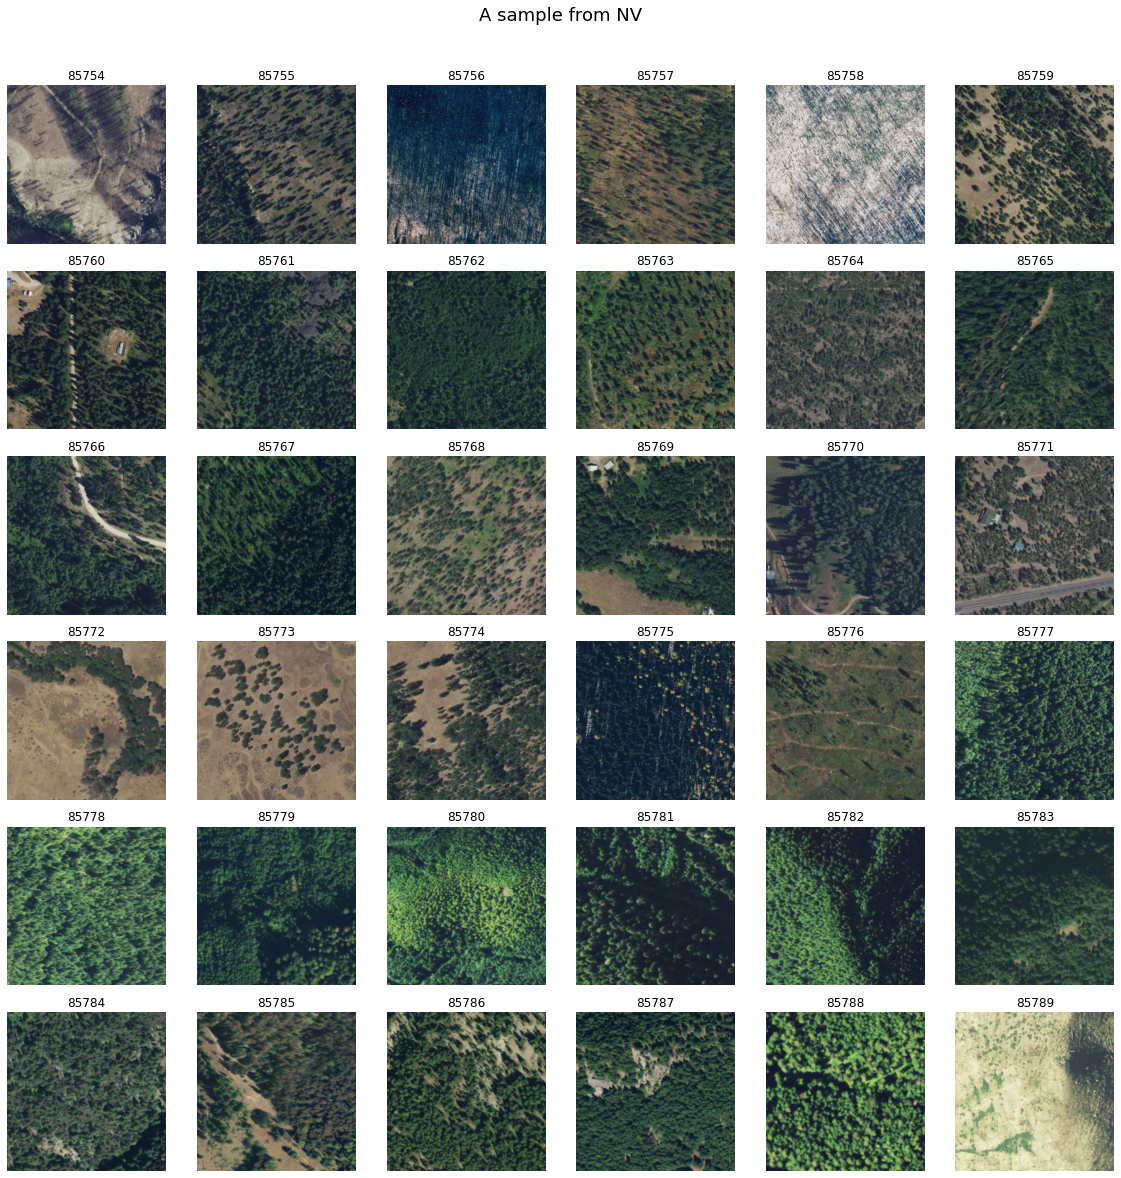

In [12]:
fig, axs = plt.subplots(6, 6, figsize=(16,16), edgecolor='k')
axs = axs.flatten()

for i in range(36):
    axs[i].imshow(image_crops[i][:,:,:3])
    axs[i].axis('off')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].set_aspect('equal')
    axs[i].set_title(labels[i])

plt.suptitle(f'A sample from {query}', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()
plt.close()
